# **TEAM MUGEN**
# **SEED Hackathon 2025**
# **Real-Time Deepfake Detection at Social Media Scale Trainning Notebook**

In [1]:
# !pip install --quiet \
#   "torch==2.2.2" \
#   "torchvision==0.17.2" \
#   "torchaudio==2.2.2" \
#   --index-url https://download.pytorch.org/whl/cu121

# !pip install --quiet facenet-pytorch

In [2]:
!python -c "import sys, torch; print('Python', sys.version); print('PyTorch', torch.__version__); print('CUDA available', torch.cuda.is_available())"

Python 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
PyTorch 2.2.2+cu121
CUDA available True


# ----- **Phase 1** Indexing of all the video datasets in a combined manner --------

In [3]:
import json
import random
from pathlib import Path

import pandas as pd

FFPP_ROOT      = Path("/kaggle/input/ff-c23/FaceForensics++_C23")
CELEBDF_ROOT   = Path("/kaggle/input/celeb-df-v2")
DFDC_ROOT      = Path("/kaggle/input/dfdcseed/dfdc")
WORK_ROOT      = Path("/kaggle/working/deepfake_detector")

random.seed(42)

rows = []

# ---------- 1) FaceForensics++ (FF++) ----------
# Structure:
#   FaceForensics++_C23/
#     original/
#     DeepFakeDetection/
#     Deepfakes/
#     Face2Face/
#     FaceShifter/
#     FaceSwap/
#     NeuralTextures/
ffpp_manip_dirs = [
    "DeepFakeDetection",
    "Deepfakes",
    "Face2Face",
    "FaceShifter",
    "FaceSwap",
    "NeuralTextures",
]
ffpp_original_dir = FFPP_ROOT / "original"

# Original (REAL)
for p in ffpp_original_dir.rglob("*.mp4"):
    clip_id = f"ffpp_orig_{p.stem}"
    rows.append({
        "clip_id": clip_id,
        "dataset": "FFPP",
        "path": str(p),
        "label": "REAL",
        "manip_type": "original",
        "source": "original",
    })

# Manipulated (FAKE)
for mdir in ffpp_manip_dirs:
    root = FFPP_ROOT / mdir
    if not root.exists():
        continue
    for p in root.rglob("*.mp4"):
        clip_id = f"ffpp_{mdir}_{p.stem}"
        rows.append({
            "clip_id": clip_id,
            "dataset": "FFPP",
            "path": str(p),
            "label": "FAKE",
            "manip_type": mdir,
            "source": "ffpp",
        })

print("FFPP clips collected:", sum(r["dataset"] == "FFPP" for r in rows))

# ---------- 2) Celeb-DF v2 ----------
# Structure (Kaggle):
#   /celeb-df-v2/
#     Celeb-real/
#     Celeb-synthesis/
#     YouTube-real/
celeb_real_dirs = [
    CELEBDF_ROOT / "Celeb-real",
    CELEBDF_ROOT / "YouTube-real",
]
celeb_fake_dir = CELEBDF_ROOT / "Celeb-synthesis"

# Real
for rdir in celeb_real_dirs:
    if not rdir.exists():
        continue
    for p in rdir.rglob("*.mp4"):
        clip_id = f"celeb_real_{p.stem}"
        rows.append({
            "clip_id": clip_id,
            "dataset": "CELEBDF",
            "path": str(p),
            "label": "REAL",
            "manip_type": "original",
            "source": "celebdf",
        })

# Fake
if celeb_fake_dir.exists():
    for p in celeb_fake_dir.rglob("*.mp4"):
        clip_id = f"celeb_fake_{p.stem}"
        rows.append({
            "clip_id": clip_id,
            "dataset": "CELEBDF",
            "path": str(p),
            "label": "FAKE",
            "manip_type": "DeepFake",
            "source": "celebdf",
        })

print("Total CELEBDF clips now:", sum(r["dataset"] == "CELEBDF" for r in rows))

# ---------- 3) DFDC parts ----------
# Structure:
#   /dfdcseed/dfdc/
#     dfdc_train_part_0/
#       metadata.json
#       *.mp4
#     dfdc_train_part_1/
#       metadata.json
#       *.mp4

for part in ["dfdc_train_part_0", "dfdc_train_part_1"]:
    part_root = DFDC_ROOT / part
    meta_path = part_root / "metadata.json"
    if not meta_path.exists():
        print("Missing metadata:", meta_path)
        continue

    with open(meta_path, "r") as f:
        meta = json.load(f)

    for fname, info in meta.items():
        vpath = part_root / fname
        if not vpath.exists():
            continue
        label = info.get("label", "").upper()  # REAL / FAKE
        split = info.get("split", "train")
        original = info.get("original", None)

        clip_id = f"{part}_{fname.replace('.mp4','')}"
        rows.append({
            "clip_id": clip_id,
            "dataset": "DFDC",
            "path": str(vpath),
            "label": label,
            "manip_type": "original" if label == "REAL" else "face_swap",
            "source": part,
            "split_hint": split,
            "original": original,
        })

print("Total DFDC clips now:", sum(r["dataset"] == "DFDC" for r in rows))

# ---------- 4) Create DataFrame & assign splits ----------
df = pd.DataFrame(rows)

def assign_split(group: pd.DataFrame) -> pd.Series:
    """
    Assigns a 'split' label to each row in the group.

    - If 'split_hint' exists and has non-NaN values (DFDC), we use that,
      filling any NaNs with 'train'.
    - Otherwise, we assign a random 80/10/10 train/val/test split,
      returning a Series indexed by group.index.
    """
    # Use explicit split if provided (DFDC)
    if "split_hint" in group.columns and group["split_hint"].notna().any():
        return group["split_hint"].fillna("train")

    # Random 80/10/10 on this dataset group
    n = len(group)
    idx = list(group.index)  # keep original row indices
    random.shuffle(idx)

    train_cut = int(0.8 * n)
    val_cut   = int(0.9 * n)

    # Initialize all as 'train' with correct index
    split = pd.Series("train", index=group.index)

    # Assign val/test using shuffled indices
    for i in idx[train_cut:val_cut]:
        split.at[i] = "val"
    for i in idx[val_cut:]:
        split.at[i] = "test"

    return split

# Apply per dataset; result is aligned with df.index (no duplicate index issue)
df["split"] = df.groupby("dataset", group_keys=False).apply(assign_split)

# Reorder columns
cols = ["clip_id", "dataset", "path", "label", "split", "manip_type", "source"]
if "split_hint" in df.columns:
    cols.append("split_hint")
if "original" in df.columns:
    cols.append("original")

df = df[cols]

# Ensure output directory exists
out_path = WORK_ROOT / "data" / "index" / "all_clips.parquet"
out_path.parent.mkdir(parents=True, exist_ok=True)

# Save
df.to_parquet(out_path)
print("Saved index to:", out_path)
print("Total clips:", len(df))

# Show quick stats
print("\nCounts by dataset and label:")
print(df.groupby(["dataset", "label"]).size())

print("\nCounts by dataset and split:")
print(df.groupby(["dataset", "split"]).size())


FFPP clips collected: 7000
Total CELEBDF clips now: 6529
Total DFDC clips now: 3033
Saved index to: /kaggle/working/deepfake_detector/data/index/all_clips.parquet
Total clips: 16562

Counts by dataset and label:
dataset  label
CELEBDF  FAKE     5639
         REAL      890
DFDC     FAKE     2839
         REAL      194
FFPP     FAKE     6000
         REAL     1000
dtype: int64

Counts by dataset and split:
dataset  split
CELEBDF  test      653
         train    5223
         val       653
DFDC     train    3033
FFPP     test      700
         train    5600
         val       700
dtype: int64


/tmp/ipykernel_117/2313599613.py:186: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df["split"] = df.groupby("dataset", group_keys=False).apply(assign_split)


In [4]:
import pandas as pd
from pathlib import Path

df = pd.read_parquet("/kaggle/working/deepfake_detector/data/index/all_clips.parquet")
print(df.head(10))

         clip_id dataset                                               path  \
0  ffpp_orig_123    FFPP  /kaggle/input/ff-c23/FaceForensics++_C23/origi...   
1  ffpp_orig_738    FFPP  /kaggle/input/ff-c23/FaceForensics++_C23/origi...   
2  ffpp_orig_479    FFPP  /kaggle/input/ff-c23/FaceForensics++_C23/origi...   
3  ffpp_orig_660    FFPP  /kaggle/input/ff-c23/FaceForensics++_C23/origi...   
4  ffpp_orig_565    FFPP  /kaggle/input/ff-c23/FaceForensics++_C23/origi...   
5  ffpp_orig_033    FFPP  /kaggle/input/ff-c23/FaceForensics++_C23/origi...   
6  ffpp_orig_726    FFPP  /kaggle/input/ff-c23/FaceForensics++_C23/origi...   
7  ffpp_orig_410    FFPP  /kaggle/input/ff-c23/FaceForensics++_C23/origi...   
8  ffpp_orig_581    FFPP  /kaggle/input/ff-c23/FaceForensics++_C23/origi...   
9  ffpp_orig_566    FFPP  /kaggle/input/ff-c23/FaceForensics++_C23/origi...   

  label  split manip_type    source split_hint original  
0  REAL  train   original  original       None     None  
1  REAL    val

## A unified Index for all the video datasets are build in a combined manner

# ------ Phase 2 - Face & Patch Extraction ----------------

In [5]:
from pathlib import Path

WORK_ROOT = Path("/kaggle/working/deepfake_detector")

faces_root = WORK_ROOT / "data" / "faces"
patches_root = WORK_ROOT / "data" / "patches"

faces_root.mkdir(parents=True, exist_ok=True)
patches_root.mkdir(parents=True, exist_ok=True)

print("Faces dir:", faces_root)
print("Patches dir:", patches_root)

Faces dir: /kaggle/working/deepfake_detector/data/faces
Patches dir: /kaggle/working/deepfake_detector/data/patches


In [6]:
# --- Patch PIL before anything else that uses it ---
import os
import types
import PIL

try:
    from PIL import _util as pil_util
except ImportError:
    pil_util = types.SimpleNamespace()
    PIL._util = pil_util

# Define is_directory if missing
if not hasattr(pil_util, "is_directory"):
    def is_directory(f):
        try:
            return os.path.isdir(f)
        except TypeError:
            return False
    pil_util.is_directory = is_directory

# Define is_path if missing (just in case)
if not hasattr(pil_util, "is_path"):
    from os import PathLike
    def is_path(f):
        return isinstance(f, (str, bytes, PathLike))
    pil_util.is_path = is_path

print("Patched PIL._util: "
      f"is_directory={hasattr(pil_util, 'is_directory')}, "
      f"is_path={hasattr(pil_util, 'is_path')}")

Patched PIL._util: is_directory=True, is_path=True


In [7]:
import torch
from facenet_pytorch import MTCNN

device = "cuda" if torch.cuda.is_available() else "cpu"
mtcnn = MTCNN(image_size=224, margin=40, keep_all=False, device=device)
print("MTCNN loaded on", device)

MTCNN loaded on cuda


In [8]:
import cv2
import math
import torch
import numpy as np
import pandas as pd
from pathlib import Path
from facenet_pytorch import MTCNN
from tqdm.auto import tqdm

WORK_ROOT = Path("/kaggle/working/deepfake_detector")
INDEX_PATH = WORK_ROOT / "data" / "index" / "all_clips.parquet"

faces_root = WORK_ROOT / "data" / "faces"
patches_root = WORK_ROOT / "data" / "patches"

device = "cuda" if torch.cuda.is_available() else "cpu"
mtcnn = MTCNN(image_size=224, margin=40, keep_all=False, device=device)

df = pd.read_parquet(INDEX_PATH)

# For now: only FFPP + DFDC, train split, to keep it light
df_sub = df[(df["dataset"].isin(["FFPP", "DFDC"])) & (df["split"] == "train")].copy()

print("Subset size:", len(df_sub))

def sample_frame_indices(num_frames, target=16):
    """Sample ~target indices from [0, num_frames-1] evenly."""
    if num_frames <= target:
        return list(range(num_frames))
    step = num_frames / target
    return [int(i * step) for i in range(target)]

def extract_faces_and_patches_for_clip(row, max_frames=16):
    clip_id = row["clip_id"]
    vpath = Path(row["path"])
    dataset = row["dataset"]
    label = row["label"]

    out_face_dir = faces_root / dataset / clip_id
    out_face_dir.mkdir(parents=True, exist_ok=True)

    out_patch_dir = patches_root / dataset / clip_id
    out_patch_dir.mkdir(parents=True, exist_ok=True)

    # Read video with OpenCV
    cap = cv2.VideoCapture(str(vpath))
    if not cap.isOpened():
        print("Failed to open:", vpath)
        return 0, 0

    num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if num_frames == 0:
        cap.release()
        return 0, 0

    frame_idxs = sample_frame_indices(num_frames, target=max_frames)

    saved_faces = 0
    saved_patches = 0

    for idx in frame_idxs:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret:
            continue

        # Convert BGR -> RGB
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Mtcnn expects PIL or Tensor; we can give numpy
        # Use mtcnn.detect or call directly; easier: convert to PIL
        from PIL import Image
        img = Image.fromarray(rgb)

        # Get aligned face crop
        face = mtcnn(img)
        if face is None:
            continue

        # face: [3, 224, 224] tensor on device; move to CPU & uint8
        face_np = (face.permute(1, 2, 0).detach().cpu().numpy() * 255).astype(np.uint8)

        # Save face
        face_fname = out_face_dir / f"frame_{idx:05d}.jpg"
        cv2.imwrite(str(face_fname), cv2.cvtColor(face_np, cv2.COLOR_RGB2BGR))
        saved_faces += 1

        # Extract a few 32x32 patches from this 224x224 face
        # Simple grid: 7x7 blocks; we pick center-of-grid patches
        h, w, _ = face_np.shape
        patch_size = 32
        # Choose a small set of patch centers: 3x3 grid in central region
        n_grid = 3
        ys = np.linspace(h*0.25, h*0.75, n_grid).astype(int)
        xs = np.linspace(w*0.25, w*0.75, n_grid).astype(int)

        patches = []
        for cy in ys:
            for cx in xs:
                y1 = max(0, cy - patch_size//2)
                x1 = max(0, cx - patch_size//2)
                y2 = min(h, y1 + patch_size)
                x2 = min(w, x1 + patch_size)
                patch = face_np[y1:y2, x1:x2, :]
                if patch.shape[0] != patch_size or patch.shape[1] != patch_size:
                    continue
                patches.append(patch)

        if patches:
            patches_arr = np.stack(patches, axis=0)  # [P, 32, 32, 3]
            patches_tensor = torch.from_numpy(patches_arr).permute(0, 3, 1, 2)  # [P,3,32,32]
            patch_fname = out_patch_dir / f"frame_{idx:05d}_patches.pt"
            torch.save({
                "patches": patches_tensor,
                "label": 0 if label == "REAL" else 1,
            }, patch_fname)
            saved_patches += patches_tensor.shape[0]

    cap.release()
    return saved_faces, saved_patches

# Testing Code 
# For safety: start with a small subset (e.g., 50 clips) to test
df_test = df_sub.sample(n=min(50, len(df_sub)), random_state=42)

total_faces = 0
total_patches = 0

for _, row in tqdm(df_test.iterrows(), total=len(df_test)):
    f, p = extract_faces_and_patches_for_clip(row)
    total_faces += f
    total_patches += p

print("Test extraction done.")
print("Total faces saved:", total_faces)
print("Total patches saved:", total_patches)

Subset size: 8633


  0%|          | 0/50 [00:00<?, ?it/s]

Test extraction done.
Total faces saved: 799
Total patches saved: 7191


## Extraction Done

In [9]:
!ls -R /kaggle/working/deepfake_detector/data/faces | head -20
!ls -R /kaggle/working/deepfake_detector/data/patches | head -20

/kaggle/working/deepfake_detector/data/faces:
DFDC
FFPP

/kaggle/working/deepfake_detector/data/faces/DFDC:
dfdc_train_part_0_ehfmarmsvo
dfdc_train_part_0_fonrexmbzz
dfdc_train_part_0_gmaghrdamw
dfdc_train_part_0_pzdfwdnmyx
dfdc_train_part_0_xlhxkekacj
dfdc_train_part_1_dwnhdzuydq
dfdc_train_part_1_eojslldtza
dfdc_train_part_1_hfxgbbeapi
dfdc_train_part_1_jfmaqowfwv
dfdc_train_part_1_jiavqbrkyk
dfdc_train_part_1_objgwnmscm
dfdc_train_part_1_oyuvnuscvz
dfdc_train_part_1_stqqcwjqsz
dfdc_train_part_1_uqrjsjwkdq
dfdc_train_part_1_yhylappzid
ls: write error: Broken pipe
/kaggle/working/deepfake_detector/data/patches:
DFDC
FFPP

/kaggle/working/deepfake_detector/data/patches/DFDC:
dfdc_train_part_0_ehfmarmsvo
dfdc_train_part_0_fonrexmbzz
dfdc_train_part_0_gmaghrdamw
dfdc_train_part_0_pzdfwdnmyx
dfdc_train_part_0_xlhxkekacj
dfdc_train_part_1_dwnhdzuydq
dfdc_train_part_1_eojslldtza
dfdc_train_part_1_hfxgbbeapi
dfdc_train_part_1_jfmaqowfwv
dfdc_train_part_1_jiavqbrkyk
dfdc_train_part_1_objgwnms

Debugging clip:
  dataset: FFPP
  clip_id: ffpp_FaceSwap_656_666
  path   : /kaggle/input/ff-c23/FaceForensics++_C23/FaceSwap/656_666.mp4
  num_frames: 383
  sampled frames: [0, 95, 191, 287]


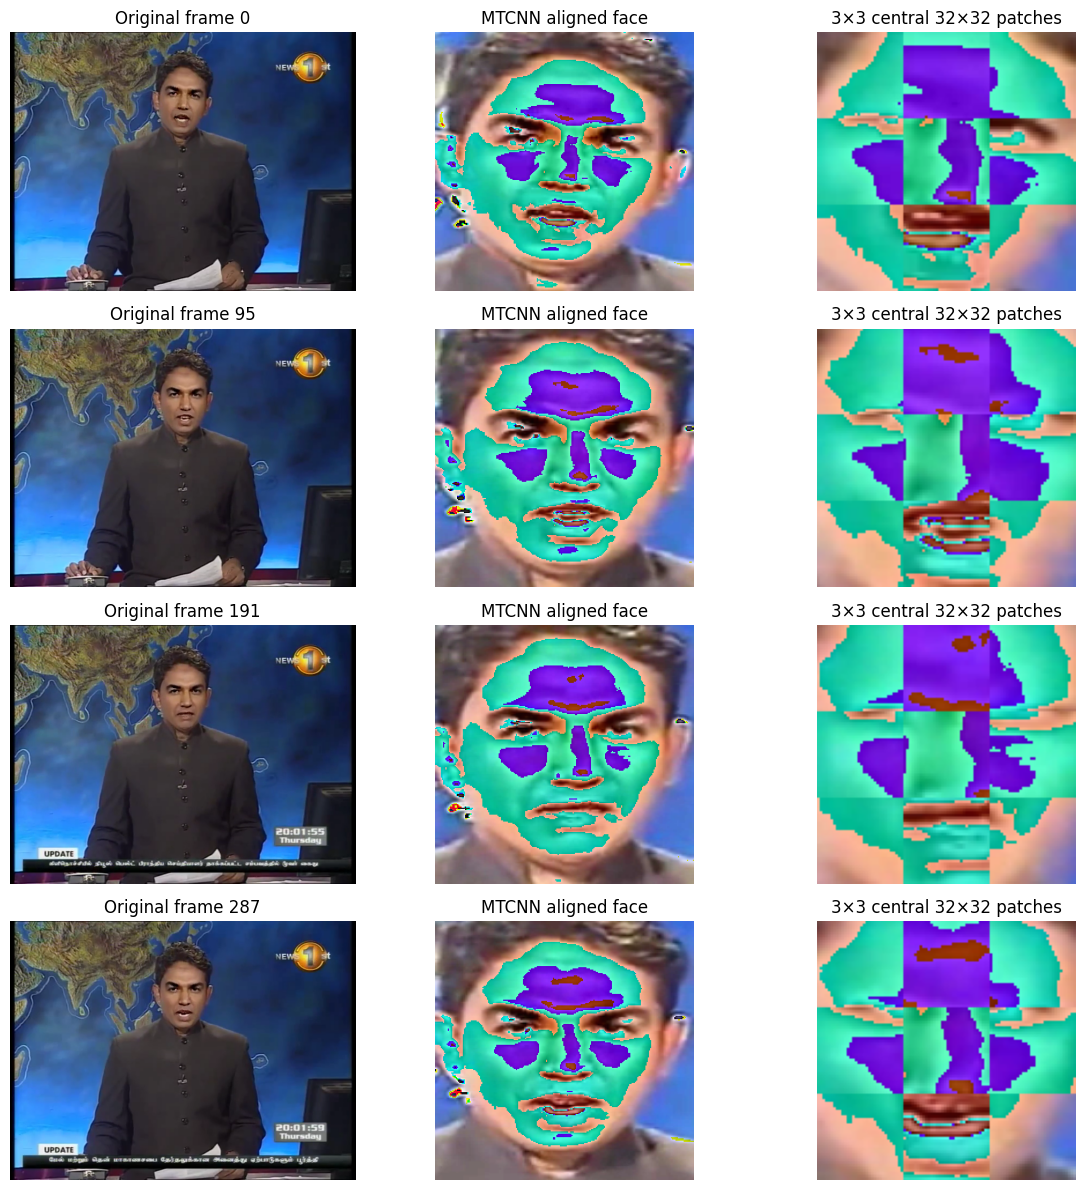

In [10]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Reuse these from earlier:
# - df_sub / df_test
# - sample_frame_indices(...)
# - mtcnn (already created with MTCNN(...))

# 1) Pick one clip we already used in df_test
debug_row = df_test.iloc[3]
vpath = debug_row["path"]
print("Debugging clip:")
print("  dataset:", debug_row["dataset"])
print("  clip_id:", debug_row["clip_id"])
print("  path   :", vpath)

# 2) Open video and choose a few frames
cap = cv2.VideoCapture(str(vpath))
num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print("  num_frames:", num_frames)

# Take e.g. 4 frames for visualization
frame_idxs = sample_frame_indices(num_frames, target=4)
print("  sampled frames:", frame_idxs)

n_frames_vis = len(frame_idxs)

fig, axes = plt.subplots(n_frames_vis, 3, figsize=(12, 3 * n_frames_vis))
if n_frames_vis == 1:
    axes = np.expand_dims(axes, 0)  # make it 2D for consistent indexing

for row_i, fidx in enumerate(frame_idxs):
    # 3) Read frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, fidx)
    ret, frame = cap.read()
    if not ret:
        print(f"[WARN] Failed to read frame {fidx}")
        continue

    # BGR → RGB
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img_pil = Image.fromarray(rgb)

    # --- Column 1: original frame ---
    ax0 = axes[row_i, 0]
    ax0.imshow(rgb)
    ax0.set_title(f"Original frame {fidx}")
    ax0.axis("off")

    # 4) MTCNN face crop
    with torch.no_grad():
        face = mtcnn(img_pil)

    ax1 = axes[row_i, 1]
    if face is None:
        ax1.set_title("No face detected")
        ax1.axis("off")
        # no patches either
        axes[row_i, 2].axis("off")
        continue

    # face: [3, 224, 224] on device
    face_np = (face.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)

    # --- Column 2: aligned face crop ---
    ax1.imshow(face_np)
    ax1.set_title("MTCNN aligned face")
    ax1.axis("off")

    # 5) Reproduce your 3x3 central 32x32 patches
    h, w, _ = face_np.shape
    patch_size = 32
    n_grid = 3
    ys = np.linspace(h * 0.25, h * 0.75, n_grid).astype(int)
    xs = np.linspace(w * 0.25, w * 0.75, n_grid).astype(int)

    patches = []
    for cy in ys:
        for cx in xs:
            y1 = max(0, cy - patch_size // 2)
            x1 = max(0, cx - patch_size // 2)
            y2 = min(h, y1 + patch_size)
            x2 = min(w, x1 + patch_size)
            patch = face_np[y1:y2, x1:x2, :]
            if patch.shape[0] == patch_size and patch.shape[1] == patch_size:
                patches.append(patch)

    ax2 = axes[row_i, 2]
    if not patches:
        ax2.set_title("No valid patches")
        ax2.axis("off")
    else:
        # Build a 3x3 mosaic image from the patches
        grid = np.zeros((n_grid * patch_size, n_grid * patch_size, 3), dtype=np.uint8)
        for i, patch in enumerate(patches[: n_grid * n_grid]):
            gy, gx = divmod(i, n_grid)
            grid[
                gy * patch_size : (gy + 1) * patch_size,
                gx * patch_size : (gx + 1) * patch_size,
                :
            ] = patch

        ax2.imshow(grid)
        ax2.set_title("3×3 central 32×32 patches")
        ax2.axis("off")

plt.tight_layout()
plt.show()

cap.release()

# Current Progress : Video → Fames → MTCNN → Faces → Patches

#  Phase 2 (part 2) – Scale extraction to a larger subset (but not all 8k+ yet)

In [11]:
# 1000 random train clips from FFPP+DFDC
N_CLIPS = min(500, len(df_sub))
df_big = df_sub.sample(n=N_CLIPS, random_state=123)

total_faces = 0
total_patches = 0

for _, row in tqdm(df_big.iterrows(), total=len(df_big)):
    f, p = extract_faces_and_patches_for_clip(row)
    total_faces += f
    total_patches += p

print("Big extraction done.")
print("Total faces saved:", total_faces)
print("Total patches saved:", total_patches)

  0%|          | 0/500 [00:00<?, ?it/s]

Big extraction done.
Total faces saved: 7943
Total patches saved: 71487


# Setting up LaDeDa

In [12]:
%cd /kaggle/working

/kaggle/working


In [13]:
!git clone https://github.com/AngRoy/RealTime-DeepfakeDetection-in-the-RealWorld.git ladeda_repo

Cloning into 'ladeda_repo'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 57 (delta 17), reused 10 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (57/57), 981.74 KiB | 6.72 MiB/s, done.
Resolving deltas: 100% (17/17), done.


In [14]:
!ls ladeda_repo

data		    LICENSE    requirements.txt  train_Tiny_LaDeDa.py
earlystop.py	    networks   test_config.py	 util.py
extract_patches.py  options    test.py		 validate.py
imgs		    README.md  train.py		 weights


In [15]:
!mkdir -p /kaggle/working/ladeda_repo/weights/Tiny_LaDeDa

In [16]:
!cp /kaggle/input/lededa/WildRF_LaDeDa.pth /kaggle/working/ladeda_repo/weights/Tiny_LaDeDa/

In [17]:
!ls /kaggle/working/ladeda_repo/weights/Tiny_LaDeDa

ForenSynth_Tiny_LaDeDa.pth  WildRF_LaDeDa.pth  WildRF_Tiny_LaDeDa.pth


In [18]:
import torch
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm

WORK_ROOT = Path("/kaggle/working/deepfake_detector")
patches_root = WORK_ROOT / "data" / "patches"

rows = []

for dataset_dir in patches_root.iterdir():
    if not dataset_dir.is_dir():
        continue
    dataset_name = dataset_dir.name  # e.g. "FFPP" or "DFDC"
    for clip_dir in dataset_dir.iterdir():
        if not clip_dir.is_dir():
            continue
        clip_id = clip_dir.name
        for pt_path in clip_dir.glob("*.pt"):
            data = torch.load(pt_path, map_location="cpu")
            label = int(data["label"])  # 0=REAL, 1=FAKE
            num_patches = data["patches"].shape[0]
            rows.append({
                "dataset": dataset_name,
                "clip_id": clip_id,
                "pt_path": str(pt_path),
                "label": label,
                "num_patches": num_patches,
            })

patch_df = pd.DataFrame(rows)
print("Total patch files:", len(patch_df))
print(patch_df.head())

patch_index_path = WORK_ROOT / "data" / "index" / "patch_index.parquet"
patch_df.to_parquet(patch_index_path)
print("Saved patch index to:", patch_index_path)

print("\nCounts by dataset & label (patch files, NOT patches):")
print(patch_df.groupby(["dataset", "label"]).size())


Total patch files: 8742
  dataset                 clip_id  \
0    FFPP  ffpp_Deepfakes_176_190   
1    FFPP  ffpp_Deepfakes_176_190   
2    FFPP  ffpp_Deepfakes_176_190   
3    FFPP  ffpp_Deepfakes_176_190   
4    FFPP  ffpp_Deepfakes_176_190   

                                             pt_path  label  num_patches  
0  /kaggle/working/deepfake_detector/data/patches...      1            9  
1  /kaggle/working/deepfake_detector/data/patches...      1            9  
2  /kaggle/working/deepfake_detector/data/patches...      1            9  
3  /kaggle/working/deepfake_detector/data/patches...      1            9  
4  /kaggle/working/deepfake_detector/data/patches...      1            9  
Saved patch index to: /kaggle/working/deepfake_detector/data/index/patch_index.parquet

Counts by dataset & label (patch files, NOT patches):
dataset  label
DFDC     0         176
         1        2842
FFPP     0         592
         1        5132
dtype: int64


In [19]:
import torch
from torch.utils.data import Dataset
import random

class PatchDataset(Dataset):
    def __init__(self, patch_df, transform=None):
        """
        patch_df: DataFrame with columns: pt_path, label, dataset, clip_id, num_patches
        """
        self.patch_df = patch_df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.patch_df)

    def __getitem__(self, idx):
        row = self.patch_df.iloc[idx]
        pt_path = row["pt_path"]
        label = row["label"]

        data = torch.load(pt_path, map_location="cpu")
        patches = data["patches"]  # [P, 3, 32, 32]
        # randomly choose one patch from this file
        p_idx = random.randint(0, patches.shape[0] - 1)
        x = patches[p_idx].float() / 255.0  # scale to [0,1]

        if self.transform is not None:
            x = self.transform(x)

        y = torch.tensor(label, dtype=torch.float32)
        return x, y


# Fine Tuning LaDeDa and Scoring 

In [20]:
# -------- Tiny-LaDeDa (official repo model) : fine-tune on our patches + score --------
import sys
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, WeightedRandomSampler
from tqdm.auto import tqdm
import numpy as np

WORK_ROOT   = Path("/kaggle/working/deepfake_detector")
LADEDA_ROOT = Path("/kaggle/working/ladeda_repo")
sys.path.append(str(LADEDA_ROOT))

from networks.Tiny_LaDeDa import tiny_ladeda  # official Tiny-LaDeDa
PRETRAINED_TINY_PATH = LADEDA_ROOT / "weights" / "Tiny_LaDeDa" / "WildRF_Tiny_LaDeDa.pth"

# -------- Train/val split on patch index --------
patch_index_path = WORK_ROOT / "data" / "index" / "patch_index.parquet"
patch_df = pd.read_parquet(patch_index_path)

train_df, val_df = train_test_split(
    patch_df,
    test_size=0.1,
    stratify=patch_df["label"],
    random_state=42,
)

print("Train patch files:", len(train_df))
print("Val patch files:", len(val_df))
print("Label distribution train:")
print(train_df["label"].value_counts())
print("Label distribution val:")
print(val_df["label"].value_counts())

# -------- Dataloaders (reuse your existing PatchDataset) --------
BATCH_SIZE = 64
NUM_EPOCHS = 50 

train_dataset = PatchDataset(train_df)
val_dataset   = PatchDataset(val_df)

# Class-balanced sampling
labels = train_df["label"].values  # 0 or 1
class_counts = [(labels == 0).sum(), (labels == 1).sum()]
total = float(len(labels))
class_weights  = [total / c for c in class_counts]
sample_weights = [class_weights[l] for l in labels]

sampler = WeightedRandomSampler(
    sample_weights,
    num_samples=len(sample_weights),
    replacement=True,
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    num_workers=4,
    pin_memory=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)

# -------- Instantiate Tiny-LaDeDa, load WildRF weights, then fine-tune --------
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# 1) Build base Tiny-LaDeDa model from the official repo
#    preprocess_type: "raw" / "NPR" / "x_grad" / "y_grad" / "left_diag" / "right_diag"
base_model = tiny_ladeda(preprocess_type="raw", num_classes=1, pool=True)

# 2) IMPORTANT: Tiny-LaDeDa backbone outputs 8-dim features, so fc in_features = 8
#    The original repo code uses 8 * block.expansion (=32) but your WildRF
#    checkpoint's fc was [1, 8] → we re-create fc to match 8-dim features.
base_model.fc = nn.Linear(8, 1)

# 3) Load pretrained WildRF weights, excluding fc.*
if PRETRAINED_TINY_PATH.exists():
    state = torch.load(PRETRAINED_TINY_PATH, map_location="cpu")

    if isinstance(state, dict) and "state_dict" in state:
        state_dict = state["state_dict"]
    else:
        state_dict = state

    clean_state = {}
    for k, v in state_dict.items():
        # Strip common prefixes
        if k.startswith("module."):
            new_k = k[len("module."):]
        elif k.startswith("model."):
            new_k = k[len("model."):]
        else:
            new_k = k

        # Drop fc.* so we re-learn on your data
        if new_k.startswith("fc."):
            continue

        clean_state[new_k] = v

    msg = base_model.load_state_dict(clean_state, strict=False)
    print("Loaded Tiny-LaDeDa pretrained weights from:", PRETRAINED_TINY_PATH)
    print("  Missing keys:", msg.missing_keys)      # expect ['fc.weight', 'fc.bias']
    print("  Unexpected keys:", msg.unexpected_keys)
else:
    print("[WARN] Pretrained Tiny-LaDeDa weights not found at", PRETRAINED_TINY_PATH)
    print("       Training Tiny-LaDeDa from scratch on your patches.")

# 4) Move to device and (optionally) wrap with DataParallel
base_model = base_model.to(device)

multi_gpu = False
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs for Tiny-LaDeDa")
    model = nn.DataParallel(base_model)
    multi_gpu = True
else:
    model = base_model

criterion = nn.BCEWithLogitsLoss()
# Smaller LR because we fine-tune a pretrained net
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

from sklearn.metrics import roc_auc_score

def run_epoch_tiny(loader, model, criterion, optimizer=None):
    is_train = optimizer is not None
    model.train(is_train)

    total_loss = 0.0
    all_labels = []
    all_probs  = []

    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        logits = model(x).squeeze(1)  # [B]
        loss   = criterion(logits, y)

        if is_train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * x.size(0)

        with torch.no_grad():
            probs = torch.sigmoid(logits)
            all_labels.append(y.detach().cpu().numpy())
            all_probs.append(probs.detach().cpu().numpy())

    total_loss /= len(loader.dataset)
    all_labels = np.concatenate(all_labels)
    all_probs  = np.concatenate(all_probs)

    try:
        auc = roc_auc_score(all_labels, all_probs)
    except ValueError:
        auc = float("nan")

    preds = (all_probs >= 0.5).astype(np.float32)
    acc   = (preds == all_labels).mean()

    return total_loss, acc, auc

best_ckpt = WORK_ROOT / "models" / "tiny_ladeda_finetuned.pth"
best_val_auc = -float("inf")
best_ckpt.parent.mkdir(parents=True, exist_ok=True)

for epoch in range(1, NUM_EPOCHS + 1):
    # training: criterion + optimizer
    train_loss, train_acc, train_auc = run_epoch_tiny(
        train_loader, model, criterion, optimizer
    )
    # validation: same criterion, but no optimizer
    val_loss, val_acc, val_auc = run_epoch_tiny(
        val_loader, model, criterion, optimizer=None
    )

    print(
        f"Epoch {epoch:02d} | "
        f"train_loss={train_loss:.4f}, train_acc={train_acc:.4f}, train_auc={train_auc:.4f} | "
        f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f}, val_auc={val_auc:.4f}"
    )

    if val_auc > best_val_auc:
        best_val_auc = val_auc
        # Save clean (no 'module.') state dict
        if multi_gpu:
            to_save = model.module.state_dict()
        else:
            to_save = model.state_dict()
        torch.save(to_save, best_ckpt)
        print(f"  ↳ New best Tiny-LaDeDa saved (val_auc={best_val_auc:.4f})")

print("Finished Tiny-LaDeDa fine-tuning. Best checkpoint:", best_ckpt)

# -------- Use finetuned Tiny-LaDeDa to score ALL patch files --------
patch_df = pd.read_parquet(patch_index_path)
print("Patch index size (all):", len(patch_df))
print(patch_df.head(3))

# Recreate Tiny-LaDeDa ***with the same fc(8→1)*** and load best finetuned weights
device = "cuda" if torch.cuda.is_available() else "cpu"
model_eval = tiny_ladeda(preprocess_type="raw", num_classes=1, pool=True)
model_eval.fc = nn.Linear(8, 1)          # same fix as training
model_eval = model_eval.to(device)

state = torch.load(best_ckpt, map_location=device)
msg = model_eval.load_state_dict(state, strict=False)
print("Loaded finetuned Tiny-LaDeDa from:", best_ckpt)
print("  Missing keys:", msg.missing_keys)
print("  Unexpected keys:", msg.unexpected_keys)

if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs for Tiny-LaDeDa (eval)")
    model_eval = nn.DataParallel(model_eval)

model_eval.eval()

results = []

for idx, row in tqdm(patch_df.iterrows(), total=len(patch_df)):
    pt_path = Path(row["pt_path"])
    data    = torch.load(pt_path, map_location="cpu")
    patches = data["patches"].float() / 255.0   # [P,3,32,32]
    label   = int(data["label"])

    if patches.ndim != 4 or patches.size(0) == 0:
        continue

    with torch.no_grad():
        x      = patches.to(device)
        logits = model_eval(x).squeeze(1)             # [P]
        probs  = torch.sigmoid(logits).cpu().numpy()  # fake probs

    results.append({
        "dataset":     row["dataset"],
        "clip_id":     row["clip_id"],
        "pt_path":     row["pt_path"],
        "label":       label,
        "num_patches": len(probs),
        "prob_mean":   float(np.mean(probs)),
        "prob_max":    float(np.max(probs)),
        "prob_min":    float(np.min(probs)),
    })

ladeda_patch_scores_df = pd.DataFrame(results)
print("Per-patch-file Tiny-LaDeDa scores shape:", ladeda_patch_scores_df.shape)
print(ladeda_patch_scores_df.head())

ladeda_patch_scores_path = WORK_ROOT / "data" / "index" / "tiny_ladeda_patch_scores.parquet"
ladeda_patch_scores_df.to_parquet(ladeda_patch_scores_path)
print("Saved Tiny-LaDeDa patch scores to:", ladeda_patch_scores_path)

# -------- Aggregate to per-clip Tiny-LaDeDa features --------
clip_scores_df = (
    ladeda_patch_scores_df
    .groupby(["dataset", "clip_id"])
    .agg(
        tiny_num_files   = ("pt_path", "size"),
        tiny_num_patches = ("num_patches", "sum"),
        tiny_prob_mean   = ("prob_mean", "mean"),
        tiny_prob_max    = ("prob_mean", "max"),
        tiny_prob_p90    = ("prob_mean", lambda x: np.percentile(x, 90)),
        label            = ("label", lambda x: x.mode().iloc[0]),
    )
    .reset_index()
)

print("Per-clip Tiny-LaDeDa scores shape:", clip_scores_df.shape)
print(clip_scores_df.head())

ladeda_clip_scores_path = WORK_ROOT / "data" / "index" / "tiny_ladeda_clip_scores.parquet"
clip_scores_df.to_parquet(ladeda_clip_scores_path)
print("Saved per-clip Tiny-LaDeDa scores to:", ladeda_clip_scores_path)


Train patch files: 7867
Val patch files: 875
Label distribution train:
label
1    7176
0     691
Name: count, dtype: int64
Label distribution val:
label
1    798
0     77
Name: count, dtype: int64
Using device: cuda
Loaded Tiny-LaDeDa pretrained weights from: /kaggle/working/ladeda_repo/weights/Tiny_LaDeDa/WildRF_Tiny_LaDeDa.pth
  Missing keys: ['fc.weight', 'fc.bias']
  Unexpected keys: []
Using 2 GPUs for Tiny-LaDeDa
Epoch 01 | train_loss=0.8444, train_acc=0.4937, train_auc=0.5177 | val_loss=1.9170, val_acc=0.0880, val_auc=0.5874
  ↳ New best Tiny-LaDeDa saved (val_auc=0.5874)
Epoch 02 | train_loss=0.7868, train_acc=0.5045, train_auc=0.5679 | val_loss=1.5823, val_acc=0.0891, val_auc=0.5464
Epoch 03 | train_loss=0.7536, train_acc=0.5313, train_auc=0.5752 | val_loss=1.3802, val_acc=0.0971, val_auc=0.5844
Epoch 04 | train_loss=0.7376, train_acc=0.5364, train_auc=0.5698 | val_loss=1.2961, val_acc=0.0971, val_auc=0.5600
Epoch 05 | train_loss=0.7165, train_acc=0.5524, train_auc=0.5777 | va

  0%|          | 0/8742 [00:00<?, ?it/s]

Per-patch-file Tiny-LaDeDa scores shape: (8742, 8)
  dataset                 clip_id  \
0    FFPP  ffpp_Deepfakes_176_190   
1    FFPP  ffpp_Deepfakes_176_190   
2    FFPP  ffpp_Deepfakes_176_190   
3    FFPP  ffpp_Deepfakes_176_190   
4    FFPP  ffpp_Deepfakes_176_190   

                                             pt_path  label  num_patches  \
0  /kaggle/working/deepfake_detector/data/patches...      1            9   
1  /kaggle/working/deepfake_detector/data/patches...      1            9   
2  /kaggle/working/deepfake_detector/data/patches...      1            9   
3  /kaggle/working/deepfake_detector/data/patches...      1            9   
4  /kaggle/working/deepfake_detector/data/patches...      1            9   

   prob_mean  prob_max  prob_min  
0   0.615967  0.714304  0.445110  
1   0.614523  0.700306  0.472333  
2   0.593289  0.701527  0.279032  
3   0.612143  0.711596  0.514688  
4   0.624143  0.716460  0.512145  
Saved Tiny-LaDeDa patch scores to: /kaggle/working/deepfake

In [21]:
import pandas as pd
from pathlib import Path

WORK_ROOT = Path("/kaggle/working/deepfake_detector")
faces_root = WORK_ROOT / "data" / "faces"

# 1) Load clip index with labels (we only need dataset, clip_id, label)
clips_df = pd.read_parquet(WORK_ROOT / "data" / "index" / "all_clips.parquet")
clips_df = clips_df[["dataset", "clip_id", "label"]].drop_duplicates()

# 2) Build raw face index from folder structure
rows = []
for dataset_dir in faces_root.iterdir():
    if not dataset_dir.is_dir():
        continue
    dataset = dataset_dir.name  # e.g. "FFPP", "DFDC"
    for clip_dir in dataset_dir.iterdir():
        if not clip_dir.is_dir():
            continue
        clip_id = clip_dir.name  # e.g. "ffpp_orig_..." or "dfdc_train_part_0_..."
        for img_path in clip_dir.glob("*.jpg"):
            rows.append(
                {
                    "dataset": dataset,
                    "clip_id": clip_id,
                    "img_path": str(img_path),
                }
            )

face_df_raw = pd.DataFrame(rows)
print("Raw face_df rows:", len(face_df_raw))

# 3) Inner join with clips_df to attach labels
face_df = face_df_raw.merge(
    clips_df,
    on=["dataset", "clip_id"],
    how="inner",   # keep only those that are in all_clips
)

print("After label join, rows:", len(face_df))
print("\nDatasets in face_df:")
print(face_df["dataset"].value_counts())
print("\nLabel distribution (faces):")
print(face_df["label"].value_counts())

face_index_path = WORK_ROOT / "data" / "index" / "face_index.parquet"
face_df.to_parquet(face_index_path)
print("\nSaved face index to:", face_index_path)

Raw face_df rows: 8742
After label join, rows: 8742

Datasets in face_df:
dataset
FFPP    5724
DFDC    3018
Name: count, dtype: int64

Label distribution (faces):
label
FAKE    7974
REAL     768
Name: count, dtype: int64

Saved face index to: /kaggle/working/deepfake_detector/data/index/face_index.parquet


# Phase 3 - Visual V0 - Frame Level CNN ( Pretrainned RESNET finetuned) 

In [22]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as T
import cv2
from PIL import Image
import random

# ImageNet normalization
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_transforms = T.Compose([
    T.Resize((256, 256)),
    T.RandomResizedCrop(224, scale=(0.8, 1.0)),
    T.RandomHorizontalFlip(),
    T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.02),
    T.ToTensor(),
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

val_transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

class FaceFrameDataset(Dataset):
    def __init__(self, df, transforms=None, max_retries=10):
        """
        df: DataFrame with at least columns ['img_path', 'label']
        label is string "REAL"/"FAKE" (from face_df)
        """
        self.df = df.reset_index(drop=True)
        self.transforms = transforms
        self.max_retries = max_retries

    def __len__(self):
        return len(self.df)

    def _load_image_cv2(self, path):
        # Read BGR from disk
        img_bgr = cv2.imread(path, cv2.IMREAD_COLOR)
        if img_bgr is None:
            raise RuntimeError(f"cv2.imread returned None for {path}")
        # Convert to RGB
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        # Wrap as PIL Image so torchvision transforms work
        img = Image.fromarray(img_rgb)
        return img

    def __getitem__(self, idx):
        tries = 0
        while tries < self.max_retries:
            row = self.df.iloc[idx]
            img_path = row["img_path"]
            label_str = row["label"]  # "REAL" or "FAKE"

            try:
                img = self._load_image_cv2(img_path)

                if self.transforms is not None:
                    img = self.transforms(img)

                label = 0.0 if label_str == "REAL" else 1.0
                label = torch.tensor(label, dtype=torch.float32)
                return img, label

            except Exception as e:
                print(f"[WARN] Failed to load {img_path}: {e}")
                tries += 1
                # pick a different random index and try again
                idx = random.randint(0, len(self.df) - 1)

        # If we get here, a lot of loads failed in a row
        raise RuntimeError("Too many failed image loads in FaceFrameDataset")

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split

face_index_path = WORK_ROOT / "data" / "index" / "face_index.parquet"
face_df = pd.read_parquet(face_index_path)

# Only FFPP + DFDC for now
face_df = face_df[face_df["dataset"].isin(["FFPP", "DFDC"])].copy()

In [24]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def is_valid_img(path):
    try:
        with Image.open(path) as im:
            im.verify()
        return True
    except Exception as e:
        print(f"[CLEAN] Dropping bad image {path}: {e}")
        return False

face_df["ok"] = face_df["img_path"].apply(is_valid_img)
face_df = face_df[face_df["ok"]].drop(columns=["ok"]).reset_index(drop=True)

In [25]:
# Stratified split on label
train_df, temp_df = train_test_split(
    face_df,
    test_size=0.2,
    stratify=face_df["label"],
    random_state=42,
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,  # 0.1 total each
    stratify=temp_df["label"],
    random_state=42,
)

print("Train faces:", len(train_df))
print("Val faces:", len(val_df))
print("Test faces:", len(test_df))
print("\nTrain label distribution:")
print(train_df["label"].value_counts())
print("\nVal label distribution:")
print(val_df["label"].value_counts())

Train faces: 6993
Val faces: 874
Test faces: 875

Train label distribution:
label
FAKE    6379
REAL     614
Name: count, dtype: int64

Val label distribution:
label
FAKE    797
REAL     77
Name: count, dtype: int64


In [26]:
from torch.utils.data import DataLoader, WeightedRandomSampler

train_dataset = FaceFrameDataset(train_df, transforms=train_transforms)
val_dataset   = FaceFrameDataset(val_df,   transforms=val_transforms)
test_dataset  = FaceFrameDataset(test_df,  transforms=val_transforms)

# Class weights for sampling (on train)
labels = (train_df["label"] == "FAKE").astype(int).values  # 0/1
class_counts = [ (labels == 0).sum(), (labels == 1).sum() ]
total = float(len(labels))
class_weights = [total / c for c in class_counts]  # inverse frequency

sample_weights = [class_weights[l] for l in labels]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

BATCH_SIZE = 64  # bigger if GPU mem allows

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    num_workers=4,
    pin_memory=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)


In [27]:
import torch
import torch.nn as nn
import torchvision.models as models

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load ImageNet-pretrained ResNet-18
backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Replace final FC
in_features = backbone.fc.in_features
backbone.fc = nn.Linear(in_features, 1)

model_v0 = backbone.to(device)

if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs for Visual v0")
    model_v0 = nn.DataParallel(model_v0)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_v0.parameters(), lr=1e-4)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 147MB/s] 

Using 2 GPUs for Visual v0


In [28]:
from sklearn.metrics import roc_auc_score
import numpy as np
from math import inf

def run_epoch_faces(loader, model, criterion, optimizer=None):
    is_train = optimizer is not None
    model.train(is_train)

    total_loss = 0.0
    all_labels = []
    all_probs  = []

    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        logits = model(imgs).squeeze(1)  # [B]
        loss = criterion(logits, labels)

        if is_train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * imgs.size(0)

        with torch.no_grad():
            probs = torch.sigmoid(logits)
            all_labels.append(labels.detach().cpu().numpy())
            all_probs.append(probs.detach().cpu().numpy())

    total_loss /= len(loader.dataset)
    all_labels = np.concatenate(all_labels)
    all_probs  = np.concatenate(all_probs)

    # compute metrics
    try:
        auc = roc_auc_score(all_labels, all_probs)
    except ValueError:
        auc = float("nan")
    preds = (all_probs >= 0.5).astype(np.float32)
    acc = (preds == all_labels).mean()

    return total_loss, acc, auc

NUM_EPOCHS = 10
best_val_auc = -inf
best_ckpt = WORK_ROOT / "models" / "visual_v0_resnet18_best.pth"
best_ckpt.parent.mkdir(parents=True, exist_ok=True)

for epoch in range(1, NUM_EPOCHS + 1):
    train_loss, train_acc, train_auc = run_epoch_faces(train_loader, model_v0, criterion, optimizer)
    val_loss, val_acc, val_auc       = run_epoch_faces(val_loader,   model_v0, criterion, optimizer=None)

    print(
        f"Epoch {epoch:02d} | "
        f"train_loss={train_loss:.4f}, train_acc={train_acc:.4f}, train_auc={train_auc:.4f} | "
        f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f}, val_auc={val_auc:.4f}"
    )

    if val_auc > best_val_auc:
        best_val_auc = val_auc
        torch.save(model_v0.state_dict(), best_ckpt)
        print("  ↳ New best model saved (val_auc={:.4f})".format(best_val_auc))


Epoch 01 | train_loss=0.2673, train_acc=0.8819, train_auc=0.9587 | val_loss=0.1539, val_acc=0.9451, val_auc=0.9860
  ↳ New best model saved (val_auc=0.9860)
Epoch 02 | train_loss=0.0684, train_acc=0.9757, train_auc=0.9974 | val_loss=0.1003, val_acc=0.9657, val_auc=0.9879
  ↳ New best model saved (val_auc=0.9879)
Epoch 03 | train_loss=0.0490, train_acc=0.9848, train_auc=0.9982 | val_loss=0.0595, val_acc=0.9771, val_auc=0.9903
  ↳ New best model saved (val_auc=0.9903)
Epoch 04 | train_loss=0.0470, train_acc=0.9850, train_auc=0.9985 | val_loss=0.0394, val_acc=0.9863, val_auc=0.9971
  ↳ New best model saved (val_auc=0.9971)
Epoch 05 | train_loss=0.0255, train_acc=0.9910, train_auc=0.9996 | val_loss=0.0384, val_acc=0.9874, val_auc=0.9973
  ↳ New best model saved (val_auc=0.9973)
Epoch 06 | train_loss=0.0185, train_acc=0.9939, train_auc=0.9998 | val_loss=0.0362, val_acc=0.9886, val_auc=0.9974
  ↳ New best model saved (val_auc=0.9974)
Epoch 07 | train_loss=0.0181, train_acc=0.9934, train_auc=

In [29]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score
import numpy as np
from pathlib import Path
import pandas as pd

WORK_ROOT = Path("/kaggle/working/deepfake_detector")

# Reload face_index and splits
face_df = pd.read_parquet(WORK_ROOT / "data" / "index" / "face_index.parquet")
face_df = face_df[face_df["dataset"].isin(["FFPP", "DFDC"])]

from sklearn.model_selection import train_test_split
train_df, temp_df = train_test_split(
    face_df,
    test_size=0.2,
    stratify=face_df["label"],
    random_state=42,
)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df["label"],
    random_state=42,
)

# Dataset & transforms (reuse your working ones)
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

class FaceFrameDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df.reset_index(drop=True)
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["img_path"]).convert("RGB")
        if self.transforms is not None:
            img = self.transforms(img)
        label = 0.0 if row["label"] == "REAL" else 1.0
        return img, torch.tensor(label, dtype=torch.float32)

test_dataset = FaceFrameDataset(test_df, transforms=val_transforms)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

device = "cuda" if torch.cuda.is_available() else "cpu"

# Build same ResNet-18 and load best weights
backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
in_features = backbone.fc.in_features
backbone.fc = nn.Linear(in_features, 1)
model_v0 = backbone.to(device)

best_ckpt = WORK_ROOT / "models" / "visual_v0_resnet18_best.pth"
state = torch.load(best_ckpt, map_location=device)

# If we ever saved {"state_dict": ...}, unwrap it
if isinstance(state, dict) and "state_dict" in state:
    state = state["state_dict"]

clean_state = {}
for k, v in state.items():
    # Remove "module." prefix if present
    if k.startswith("module."):
        new_k = k[len("module."):]
    else:
        new_k = k
    clean_state[new_k] = v

msg = model_v0.load_state_dict(clean_state, strict=True)
print("Loaded visual_v0 from:", best_ckpt)
print("Missing keys:", msg.missing_keys)
print("Unexpected keys:", msg.unexpected_keys)
model_v0.eval()

all_labels = []
all_probs  = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        logits = model_v0(imgs).squeeze(1)
        probs  = torch.sigmoid(logits)

        all_labels.append(labels.cpu().numpy())
        all_probs.append(probs.cpu().numpy())

all_labels = np.concatenate(all_labels)
all_probs  = np.concatenate(all_probs)

from sklearn.metrics import accuracy_score
preds = (all_probs >= 0.5).astype(np.float32)

test_acc = accuracy_score(all_labels, preds)
try:
    test_auc = roc_auc_score(all_labels, all_probs)
except ValueError:
    test_auc = float("nan")

print(f"Visual v0 – test_acc={test_acc:.4f}, test_auc={test_auc:.44f}")

Loaded visual_v0 from: /kaggle/working/deepfake_detector/models/visual_v0_resnet18_best.pth
Missing keys: []
Unexpected keys: []
Visual v0 – test_acc=0.9874, test_auc=0.99791687009732121804717053237254731357097626


In [30]:
from tqdm.auto import tqdm

# reuse model_v0 and val_transforms from above
model_v0.eval()

rows = []

for idx, row in tqdm(face_df.iterrows(), total=len(face_df)):
    img_path = row["img_path"]
    label_str = row["label"]
    dataset = row["dataset"]
    clip_id = row["clip_id"]

    img = Image.open(img_path).convert("RGB")
    img_t = val_transforms(img).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model_v0(img_t).squeeze(1)
        prob_fake = torch.sigmoid(logits).item()

    label = 0 if label_str == "REAL" else 1

    rows.append({
        "dataset": dataset,
        "clip_id": clip_id,
        "img_path": img_path,
        "label": label,
        "prob_fake": prob_fake,
    })

faces_scores_df = pd.DataFrame(rows)
print("faces_scores_df shape:", faces_scores_df.shape)
print(faces_scores_df.head())

faces_scores_path = WORK_ROOT / "data" / "index" / "visual_v0_face_scores.parquet"
faces_scores_df.to_parquet(faces_scores_path)
print("Saved face scores to:", faces_scores_path)

  0%|          | 0/8742 [00:00<?, ?it/s]

faces_scores_df shape: (8742, 5)
  dataset                 clip_id  \
0    FFPP  ffpp_Deepfakes_176_190   
1    FFPP  ffpp_Deepfakes_176_190   
2    FFPP  ffpp_Deepfakes_176_190   
3    FFPP  ffpp_Deepfakes_176_190   
4    FFPP  ffpp_Deepfakes_176_190   

                                            img_path  label  prob_fake  
0  /kaggle/working/deepfake_detector/data/faces/F...      1   0.999023  
1  /kaggle/working/deepfake_detector/data/faces/F...      1   0.999622  
2  /kaggle/working/deepfake_detector/data/faces/F...      1   0.999978  
3  /kaggle/working/deepfake_detector/data/faces/F...      1   0.999710  
4  /kaggle/working/deepfake_detector/data/faces/F...      1   0.999692  
Saved face scores to: /kaggle/working/deepfake_detector/data/index/visual_v0_face_scores.parquet


In [31]:
import numpy as np

def agg_clip_visual(group):
    probs = group["prob_fake"].values
    return pd.Series({
        "visual_num_faces": len(probs),
        "visual_prob_mean": float(np.mean(probs)),
        "visual_prob_max":  float(np.max(probs)),
        "visual_prob_p90":  float(np.percentile(probs, 90)),
        "label": int(group["label"].mode().iloc[0]),
    })

visual_clip_df = (
    faces_scores_df
    .groupby(["dataset", "clip_id"])
    .apply(agg_clip_visual)
    .reset_index()
)

print("visual_clip_df shape:", visual_clip_df.shape)
print(visual_clip_df.head())

visual_clip_scores_path = WORK_ROOT / "data" / "index" / "visual_v0_clip_scores.parquet"
visual_clip_df.to_parquet(visual_clip_scores_path)
print("Saved visual clip scores to:", visual_clip_scores_path)

visual_clip_df shape: (550, 7)
  dataset                       clip_id  visual_num_faces  visual_prob_mean  \
0    DFDC  dfdc_train_part_0_ajeegjgyzk              16.0          0.946584   
1    DFDC  dfdc_train_part_0_atrteuctxr              16.0          0.999721   
2    DFDC  dfdc_train_part_0_atzwrsivnb              16.0          0.977081   
3    DFDC  dfdc_train_part_0_augwyjvlqa              16.0          0.975675   
4    DFDC  dfdc_train_part_0_bqamrsyvnf              16.0          0.823866   

   visual_prob_max  visual_prob_p90  label  
0         0.999988         0.999951    1.0  
1         0.999970         0.999965    1.0  
2         0.999697         0.999289    1.0  
3         0.999848         0.999503    1.0  
4         0.999915         0.999729    1.0  
Saved visual clip scores to: /kaggle/working/deepfake_detector/data/index/visual_v0_clip_scores.parquet


/tmp/ipykernel_117/4198830556.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(agg_clip_visual)


In [32]:
clips_df = pd.read_parquet(WORK_ROOT / "data" / "index" / "all_clips.parquet")

ladeda_clip = pd.read_parquet(
    WORK_ROOT / "data" / "index" / "tiny_ladeda_clip_scores.parquet"
)
visual_clip = pd.read_parquet(
    WORK_ROOT / "data" / "index" / "visual_v0_clip_scores.parquet"
)

# unify label to int 0/1 in clips_df for join
clips_df["label_int"] = clips_df["label"].map({"REAL": 0, "FAKE": 1})

# we only have TinyLaDeDa + visual features for FFPP + DFDC subset right now
clips_sub = clips_df[clips_df["dataset"].isin(["FFPP", "DFDC"])]

fusion_df = (
    clips_sub[["dataset", "clip_id", "label_int"]]
    .merge(ladeda_clip, on=["dataset", "clip_id"], how="inner", suffixes=("", "_ladeda"))
    .merge(visual_clip, on=["dataset", "clip_id"], how="inner", suffixes=("", "_visual"))
)

print("Fusion table shape:", fusion_df.shape)
print(fusion_df.head())


Fusion table shape: (550, 14)
  dataset        clip_id  label_int  tiny_num_files  tiny_num_patches  \
0    FFPP  ffpp_orig_161          0              16               144   
1    FFPP  ffpp_orig_822          0              16               144   
2    FFPP  ffpp_orig_845          0              16               144   
3    FFPP  ffpp_orig_392          0              16               144   
4    FFPP  ffpp_orig_144          0              16               144   

   tiny_prob_mean  tiny_prob_max  tiny_prob_p90  label  visual_num_faces  \
0        0.418092       0.466366       0.455037      0              16.0   
1        0.476978       0.506239       0.491079      0              16.0   
2        0.427752       0.436525       0.434846      0              16.0   
3        0.485204       0.516196       0.499858      0              16.0   
4        0.607443       0.628179       0.622645      0              16.0   

   visual_prob_mean  visual_prob_max  visual_prob_p90  label_visual  
0   

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score

# choose feature columns
feature_cols = [
    "tiny_prob_mean",
    "tiny_prob_max",
    "tiny_prob_p90",
    "visual_prob_mean",
    "visual_prob_max",
    "visual_prob_p90",
    "visual_num_faces",
    "tiny_num_files",
    "tiny_num_patches",
]

X = fusion_df[feature_cols].values
y = fusion_df["label_int"].values

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# logistic regression with scaling
clf = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000)),
])

clf.fit(X_train, y_train)

y_val_prob = clf.predict_proba(X_val)[:, 1]
y_val_pred = (y_val_prob >= 0.5).astype(int)

clip_auc = roc_auc_score(y_val, y_val_prob)
print("Clip-level fusion AUC:", clip_auc)
print(classification_report(y_val, y_val_pred, digits=4))


Clip-level fusion AUC: 1.0
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        10
           1     1.0000    1.0000    1.0000       100

    accuracy                         1.0000       110
   macro avg     1.0000    1.0000    1.0000       110
weighted avg     1.0000    1.0000    1.0000       110



In [34]:
import joblib
fusion_model_path = WORK_ROOT / "models" / "clip_fusion_logreg.joblib"
joblib.dump({"model": clf, "feature_cols": feature_cols}, fusion_model_path)
print("Saved fusion model to:", fusion_model_path)


Saved fusion model to: /kaggle/working/deepfake_detector/models/clip_fusion_logreg.joblib


# Audio Pipeline for trainning on asvpoof dataset 

In [35]:
from pathlib import Path
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split

WORK_ROOT = Path("/kaggle/working/deepfake_detector")

ASVSPOOF_ROOT = Path("/kaggle/input/asvpoof-2019-dataset") / "LA" / "LA"
CM_PROTO_DIR   = ASVSPOOF_ROOT / "ASVspoof2019_LA_cm_protocols"

TRAIN_FLAC_DIR = ASVSPOOF_ROOT / "ASVspoof2019_LA_train" / "flac"
DEV_FLAC_DIR   = ASVSPOOF_ROOT / "ASVspoof2019_LA_dev"   / "flac"
EVAL_FLAC_DIR  = ASVSPOOF_ROOT / "ASVspoof2019_LA_eval"  / "flac"  # we won't use eval for training now

AUDIO_INDEX_DIR = WORK_ROOT / "data" / "index"
AUDIO_INDEX_DIR.mkdir(parents=True, exist_ok=True)

# --- Subset controls (tweak these) ---
MAX_TRAIN_PER_CLASS = 2000   # None = use all; else cap per (bonafide/spoof)
MAX_DEV_PER_CLASS   = 1000
RANDOM_SEED         = 42

In [36]:
def load_la_cm_protocol(split: str) -> pd.DataFrame:
    """
    split: 'train' or 'dev'
    Returns columns: [split, speaker_id, utt_id, system_id, attack, label_str, label_int, path]
    label_int: 0 = bonafide (REAL), 1 = spoof (FAKE)
    """
    if split == "train":
        proto_path = CM_PROTO_DIR / "ASVspoof2019.LA.cm.train.trn.txt"
        flac_dir   = TRAIN_FLAC_DIR
    elif split == "dev":
        proto_path = CM_PROTO_DIR / "ASVspoof2019.LA.cm.dev.trl.txt"
        flac_dir   = DEV_FLAC_DIR
    else:
        raise ValueError("split must be 'train' or 'dev'")

    # Protocol: speaker_id, utt_id, system_id, attack_id_or_dash, label_str
    df = pd.read_csv(
        proto_path,
        sep=" ",
        header=None,
        names=["speaker_id", "utt_id", "system_id", "attack_id", "label_str"],
    )

    df["split"] = split
    df["label_int"] = (df["label_str"] == "spoof").astype(int)  # spoof=1, bonafide=0
    df["path"] = df["utt_id"].apply(lambda u: str(flac_dir / f"{u}.flac"))

    return df


train_proto_df = load_la_cm_protocol("train")
dev_proto_df   = load_la_cm_protocol("dev")

print("Train protocol size:", len(train_proto_df))
print(train_proto_df.head())
print("Dev protocol size:", len(dev_proto_df))
print(dev_proto_df.head())

Train protocol size: 25380
  speaker_id        utt_id system_id attack_id label_str  split  label_int  \
0    LA_0079  LA_T_1138215         -         -  bonafide  train          0   
1    LA_0079  LA_T_1271820         -         -  bonafide  train          0   
2    LA_0079  LA_T_1272637         -         -  bonafide  train          0   
3    LA_0079  LA_T_1276960         -         -  bonafide  train          0   
4    LA_0079  LA_T_1341447         -         -  bonafide  train          0   

                                                path  
0  /kaggle/input/asvpoof-2019-dataset/LA/LA/ASVsp...  
1  /kaggle/input/asvpoof-2019-dataset/LA/LA/ASVsp...  
2  /kaggle/input/asvpoof-2019-dataset/LA/LA/ASVsp...  
3  /kaggle/input/asvpoof-2019-dataset/LA/LA/ASVsp...  
4  /kaggle/input/asvpoof-2019-dataset/LA/LA/ASVsp...  
Dev protocol size: 24844
  speaker_id        utt_id system_id attack_id label_str split  label_int  \
0    LA_0069  LA_D_1047731         -         -  bonafide   dev          

In [37]:
def subset_by_class(df: pd.DataFrame, max_per_class: int | None, seed: int = 42) -> pd.DataFrame:
    if max_per_class is None:
        return df

    dfs = []
    rng = np.random.default_rng(seed)
    for lbl in [0, 1]:
        df_lbl = df[df["label_int"] == lbl]
        if len(df_lbl) > max_per_class:
            idx = rng.choice(df_lbl.index, size=max_per_class, replace=False)
            df_lbl = df_lbl.loc[idx]
        dfs.append(df_lbl)
    return pd.concat(dfs).sample(frac=1.0, random_state=seed).reset_index(drop=True)


train_audio_df = subset_by_class(train_proto_df, MAX_TRAIN_PER_CLASS, RANDOM_SEED)
dev_audio_df   = subset_by_class(dev_proto_df,   MAX_DEV_PER_CLASS,   RANDOM_SEED)

print("After subsetting:")
print("  Train:", len(train_audio_df), "per label:\n", train_audio_df["label_int"].value_counts())
print("  Dev:",   len(dev_audio_df),   "per label:\n", dev_audio_df["label_int"].value_counts())

audio_index_path = AUDIO_INDEX_DIR / "asvspoof_la_index.parquet"
pd.concat([train_audio_df, dev_audio_df]).to_parquet(audio_index_path)
print("Saved ASVspoof LA index to:", audio_index_path)


After subsetting:
  Train: 4000 per label:
 label_int
0    2000
1    2000
Name: count, dtype: int64
  Dev: 2000 per label:
 label_int
1    1000
0    1000
Name: count, dtype: int64
Saved ASVspoof LA index to: /kaggle/working/deepfake_detector/data/index/asvspoof_la_index.parquet


In [38]:
import librosa
import scipy.fftpack

def compute_cqcc(
    y: np.ndarray,
    sr: int,
    hop_length: int = 256,
    fmin: float = 20.0,
    n_bins: int = 96,
    bins_per_octave: int = 12,
    n_ceps: int = 30,
) -> np.ndarray:
    """
    Compute CQCC-like features:
      1) CQT magnitude
      2) log-power
      3) DCT over frequency (cepstra)
      4) Δ and ΔΔ concatenated
    Returns: [3 * n_ceps, T_frames] float32
    """
    if len(y) < hop_length * 2:
        y = np.pad(y, (0, hop_length * 2 - len(y)), mode="constant")
    
    # 1) CQT
    C = librosa.cqt(
        y,
        sr=sr,
        hop_length=hop_length,
        fmin=fmin,
        n_bins=n_bins,
        bins_per_octave=bins_per_octave,
    )
    S = np.abs(C) ** 2  # power
    S_log = np.log(S + 1e-12)

    # 2) DCT along frequency axis -> cepstral coeffs
    cqcc = scipy.fftpack.dct(S_log, type=2, axis=0, norm="ortho")
    cqcc = cqcc[:n_ceps, :]  # [n_ceps, T]

    # 3) Δ and ΔΔ
    delta  = librosa.feature.delta(cqcc)
    delta2 = librosa.feature.delta(cqcc, order=2)

    feats = np.concatenate([cqcc, delta, delta2], axis=0)  # [3*n_ceps, T]
    return feats.astype(np.float32)


In [39]:
def crop_or_pad(feats: np.ndarray, max_frames: int, train: bool) -> np.ndarray:
    """
    feats: [F, T]
    returns: [F, max_frames]
    """
    F, T = feats.shape
    if T == max_frames:
        return feats
    if T < max_frames:
        pad = max_frames - T
        return np.pad(feats, ((0, 0), (0, pad)), mode="constant")

    # T > max_frames
    if train:
        start = np.random.randint(0, T - max_frames + 1)
    else:
        start = (T - max_frames) // 2
    return feats[:, start:start + max_frames]


In [40]:
class ASVspoofCQCCDataset(Dataset):
    def __init__(self, df: pd.DataFrame, max_frames: int = 400, train: bool = True, sr: int = 16000):
        self.df = df.reset_index(drop=True)
        self.max_frames = max_frames
        self.train = train
        self.sr = sr

        self.min_samples = 2048  # or 4096 if you prefer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = row["path"]
        label = row["label_int"]

        # Load audio
        y, sr = librosa.load(path, sr=self.sr)

        # NEW: pad very short signals so librosa's internal STFT/CQT doesn't complain
        if len(y) < self.min_samples:
            pad_width = self.min_samples - len(y)
            y = np.pad(y, (0, pad_width), mode="constant")

        # CQCC feats -> [F, T]
        feats = compute_cqcc(y, sr)

        # Crop/pad along time axis -> [F, max_frames]
        feats = crop_or_pad(feats, self.max_frames, train=self.train)

        x = torch.from_numpy(feats).unsqueeze(0)  # [1,F,T]
        y_label = torch.tensor(float(label), dtype=torch.float32)

        return x, y_label

In [41]:
import torch.nn as nn
import torch.nn.functional as F

class CQCCCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,   32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32,  64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4   = nn.BatchNorm2d(256)

        self.pool  = nn.MaxPool2d(kernel_size=2, stride=2)

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, 1)  # binary logit

    def forward(self, x):
        # x: [B, 1, F, T]
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # [B,32, F/2, T/2]
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # [B,64, ...]
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # [B,128,...]
        x = self.pool(F.relu(self.bn4(self.conv4(x))))  # [B,256,...]

        x = self.global_pool(x)                         # [B,256,1,1]
        x = x.view(x.size(0), -1)                       # [B,256]
        x = self.fc(x).squeeze(1)                       # [B]
        return x


In [42]:
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.metrics import roc_auc_score
from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Audio device:", device)

MAX_FRAMES = 1000

train_ds = ASVspoofCQCCDataset(train_audio_df, max_frames=MAX_FRAMES, train=True)
val_ds   = ASVspoofCQCCDataset(dev_audio_df,   max_frames=MAX_FRAMES, train=False)

BATCH_SIZE = 32
NUM_EPOCHS = 10

# Class-balanced sampling for training
labels_train = train_audio_df["label_int"].values
class_counts = [(labels_train == 0).sum(), (labels_train == 1).sum()]
total = float(len(labels_train))
class_weights = [total / c for c in class_counts]
sample_weights = [class_weights[l] for l in labels_train]

sampler = WeightedRandomSampler(
    sample_weights,
    num_samples=len(sample_weights),
    replacement=True,
)

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    num_workers=0,
    pin_memory=True,
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)

audio_model = CQCCCNN().to(device)
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs for audio CQCC-CNN")
    audio_model = nn.DataParallel(audio_model)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(audio_model.parameters(), lr=1e-4)


Audio device: cuda
Using 2 GPUs for audio CQCC-CNN


In [43]:
def run_epoch_audio(loader, model, criterion, optimizer=None):
    is_train = optimizer is not None
    model.train(is_train)

    total_loss = 0.0
    all_labels = []
    all_probs  = []

    for x, y in tqdm(loader, leave=False):
        x = x.to(device, non_blocking=True)  # [B,1,F,T]
        y = y.to(device)

        logits = model(x)        # [B]
        loss   = criterion(logits, y)

        if is_train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * x.size(0)

        with torch.no_grad():
            probs = torch.sigmoid(logits)
            all_labels.append(y.detach().cpu().numpy())
            all_probs.append(probs.detach().cpu().numpy())

    total_loss /= len(loader.dataset)
    all_labels = np.concatenate(all_labels)
    all_probs  = np.concatenate(all_probs)

    try:
        auc = roc_auc_score(all_labels, all_probs)
    except ValueError:
        auc = float("nan")

    preds = (all_probs >= 0.5).astype(np.float32)
    acc   = (preds == all_labels).mean()

    return total_loss, acc, auc


In [44]:
audio_ckpt_path = WORK_ROOT / "models" / "audio_cqcc_cnn_asvspoof_la.pth"
audio_ckpt_path.parent.mkdir(parents=True, exist_ok=True)

best_val_auc = -float("inf")
multi_gpu = isinstance(audio_model, nn.DataParallel)

for epoch in range(1, NUM_EPOCHS + 1):
    train_loss, train_acc, train_auc = run_epoch_audio(
        train_loader, audio_model, criterion, optimizer
    )
    val_loss, val_acc, val_auc = run_epoch_audio(
        val_loader, audio_model, criterion, optimizer=None
    )

    print(
        f"Epoch {epoch:02d} | "
        f"train_loss={train_loss:.4f}, train_acc={train_acc:.4f}, train_auc={train_auc:.4f} | "
        f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f}, val_auc={val_auc:.4f}"
    )

    if val_auc > best_val_auc:
        best_val_auc = val_auc
        state_to_save = audio_model.module.state_dict() if multi_gpu else audio_model.state_dict()
        torch.save(state_to_save, audio_ckpt_path)
        print(f"  ↳ New best audio model saved (val_auc={best_val_auc:.4f}) to {audio_ckpt_path}")

print("Finished training audio CQCC-CNN. Best val AUC:", best_val_auc)

  0%|          | 0/125 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=113
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=125
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=98
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=121
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=118
  warnings.warn(


  0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=122
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=125
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=116
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=127
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=124
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=110
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWa

Epoch 01 | train_loss=0.5515, train_acc=0.7725, train_auc=0.8532 | val_loss=0.4375, val_acc=0.8945, val_auc=0.9052
  ↳ New best audio model saved (val_auc=0.9052) to /kaggle/working/deepfake_detector/models/audio_cqcc_cnn_asvspoof_la.pth


  0%|          | 0/125 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=121
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=113
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=118
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=106
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=94
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=105
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWar

  0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=122
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=125
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=116
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=127
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=124
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=110
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWa

Epoch 02 | train_loss=0.4176, train_acc=0.8802, train_auc=0.9158 | val_loss=0.3825, val_acc=0.8695, val_auc=0.9242
  ↳ New best audio model saved (val_auc=0.9242) to /kaggle/working/deepfake_detector/models/audio_cqcc_cnn_asvspoof_la.pth


  0%|          | 0/125 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=94
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=121
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=127
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=118
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=85
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=106
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarn

  0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=122
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=125
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=116
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=127
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=124
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=110
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWa

Epoch 03 | train_loss=0.3344, train_acc=0.9077, train_auc=0.9523 | val_loss=0.3356, val_acc=0.9015, val_auc=0.9363
  ↳ New best audio model saved (val_auc=0.9363) to /kaggle/working/deepfake_detector/models/audio_cqcc_cnn_asvspoof_la.pth


  0%|          | 0/125 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=118
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=124
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=121
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=127
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=113
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=98
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWar

  0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=122
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=125
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=116
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=127
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=124
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=110
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWa

Epoch 04 | train_loss=0.2913, train_acc=0.9165, train_auc=0.9657 | val_loss=0.3433, val_acc=0.8540, val_auc=0.9656
  ↳ New best audio model saved (val_auc=0.9656) to /kaggle/working/deepfake_detector/models/audio_cqcc_cnn_asvspoof_la.pth


  0%|          | 0/125 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=118
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=121
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=85
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=127
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=98
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=106
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarn

  0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=122
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=125
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=116
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=127
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=124
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=110
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWa

Epoch 05 | train_loss=0.2483, train_acc=0.9317, train_auc=0.9803 | val_loss=0.3056, val_acc=0.8940, val_auc=0.9672
  ↳ New best audio model saved (val_auc=0.9672) to /kaggle/working/deepfake_detector/models/audio_cqcc_cnn_asvspoof_la.pth


  0%|          | 0/125 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=85
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=121
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=98
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=94
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=118
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=106
  warnings.warn(


  0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=122
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=125
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=116
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=127
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=124
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=110
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWa

Epoch 06 | train_loss=0.2203, train_acc=0.9460, train_auc=0.9829 | val_loss=0.2686, val_acc=0.9070, val_auc=0.9793
  ↳ New best audio model saved (val_auc=0.9793) to /kaggle/working/deepfake_detector/models/audio_cqcc_cnn_asvspoof_la.pth


  0%|          | 0/125 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=106
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=121
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=98
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=127
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=124
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=118
  warnings.warn(


  0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=122
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=125
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=116
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=127
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=124
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=110
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWa

Epoch 07 | train_loss=0.1955, train_acc=0.9490, train_auc=0.9871 | val_loss=0.4314, val_acc=0.8260, val_auc=0.9708


  0%|          | 0/125 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=121
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=127
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=98
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=118
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=85
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=105
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarn

  0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=122
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=125
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=116
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=127
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=124
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=110
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWa

Epoch 08 | train_loss=0.1655, train_acc=0.9607, train_auc=0.9929 | val_loss=0.2306, val_acc=0.9200, val_auc=0.9811
  ↳ New best audio model saved (val_auc=0.9811) to /kaggle/working/deepfake_detector/models/audio_cqcc_cnn_asvspoof_la.pth


  0%|          | 0/125 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=98
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=121
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=118
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=105
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=124
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=106
  warnings.warn(


  0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=122
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=125
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=116
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=127
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=124
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=110
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWa

Epoch 09 | train_loss=0.1413, train_acc=0.9680, train_auc=0.9950 | val_loss=0.1879, val_acc=0.9390, val_auc=0.9821
  ↳ New best audio model saved (val_auc=0.9821) to /kaggle/working/deepfake_detector/models/audio_cqcc_cnn_asvspoof_la.pth


  0%|          | 0/125 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=105
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=106
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=113
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=121
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=85
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=127
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWar

  0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=122
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=125
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=116
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=127
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=124
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=110
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWa

Epoch 10 | train_loss=0.1452, train_acc=0.9635, train_auc=0.9924 | val_loss=0.1817, val_acc=0.9385, val_auc=0.9840
  ↳ New best audio model saved (val_auc=0.9840) to /kaggle/working/deepfake_detector/models/audio_cqcc_cnn_asvspoof_la.pth
Finished training audio CQCC-CNN. Best val AUC: 0.9840260000000001


In [45]:
# Reload best model cleanly for eval
audio_eval = CQCCCNN().to(device)
state = torch.load(audio_ckpt_path, map_location=device)
audio_eval.load_state_dict(state)
if torch.cuda.device_count() > 1:
    audio_eval = nn.DataParallel(audio_eval)
audio_eval.eval()

def score_split(df: pd.DataFrame, split_name: str) -> pd.DataFrame:
    ds = ASVspoofCQCCDataset(df, max_frames=MAX_FRAMES, train=False)
    loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=4, pin_memory=True)

    all_rows = []
    idx_iter = iter(df.itertuples(index=False))

    with torch.no_grad():
        for x, y in tqdm(loader, desc=f"Scoring {split_name}"):
            x = x.to(device)
            logits = audio_eval(x)
            probs  = torch.sigmoid(logits).cpu().numpy()
            labels = y.numpy()

            for prob, lbl, row in zip(probs, labels, idx_iter):
                all_rows.append({
                    "split": split_name,
                    "utt_id": row.utt_id,
                    "path": row.path,
                    "label_int": int(lbl),
                    "audio_prob_fake": float(prob),
                })

    return pd.DataFrame(all_rows)

audio_train_scores = score_split(train_audio_df, "train")
audio_dev_scores   = score_split(dev_audio_df,   "dev")

audio_scores_df = pd.concat([audio_train_scores, audio_dev_scores], ignore_index=True)
audio_scores_path = AUDIO_INDEX_DIR / "asvspoof_la_audio_scores.parquet"
audio_scores_df.to_parquet(audio_scores_path)
print("Saved audio scores to:", audio_scores_path)
print(audio_scores_df.head())

Scoring train:   0%|          | 0/125 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=121
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=121
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=124
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=127
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=85
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=125
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWar

Scoring dev:   0%|          | 0/63 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=122
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=122
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=125
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=116
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=127
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=128 is too large for input signal of length=124
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWa

Saved audio scores to: /kaggle/working/deepfake_detector/data/index/asvspoof_la_audio_scores.parquet
   split        utt_id                                               path  \
0  train  LA_T_9293135  /kaggle/input/asvpoof-2019-dataset/LA/LA/ASVsp...   
1  train  LA_T_1255177  /kaggle/input/asvpoof-2019-dataset/LA/LA/ASVsp...   
2  train  LA_T_5656942  /kaggle/input/asvpoof-2019-dataset/LA/LA/ASVsp...   
3  train  LA_T_8404999  /kaggle/input/asvpoof-2019-dataset/LA/LA/ASVsp...   
4  train  LA_T_8891107  /kaggle/input/asvpoof-2019-dataset/LA/LA/ASVsp...   

   label_int  audio_prob_fake  
0          0         0.022350  
1          1         0.990925  
2          0         0.014022  
3          1         0.856270  
4          1         0.998144  


# Audio Extraction From Video and Trainning 

In [46]:
import torch
import numpy as np
import librosa

# Reuse these from your previous cells :
# - compute_cqcc
# - crop_or_pad
# - CQCCCNN
# - MAX_FRAMES

device = "cuda" if torch.cuda.is_available() else "cpu"

# Reload best audio model for inference
audio_ckpt_path = WORK_ROOT / "models" / "audio_cqcc_cnn_asvspoof_la.pth"
audio_infer = CQCCCNN().to(device)
state = torch.load(audio_ckpt_path, map_location=device)
audio_infer.load_state_dict(state)
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs for audio inference")
    audio_infer = torch.nn.DataParallel(audio_infer)
audio_infer.eval()

def infer_audio_file(
    audio_path: str | Path,
    sr: int = 16000,
    max_frames: int = 400,
) -> float:
    """
    Given a .wav or .flac path, return audio_prob_fake in [0,1].
    Uses same CQCC pipeline and center-crop logic as validation.
    """
    audio_path = str(audio_path)
    # 1) Load & resample
    y, sr_loaded = librosa.load(audio_path, sr=sr)

    # 2) CQCC feats [F, T]
    feats = compute_cqcc(y, sr)

    # 3) Center-crop / pad to max_frames (like train=False)
    feats = crop_or_pad(feats, max_frames, train=False)  # [F, max_frames]

    # 4) To tensor [1,1,F,T]
    x = torch.from_numpy(feats).unsqueeze(0).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = audio_infer(x)     # [1]
        prob_fake = torch.sigmoid(logits).item()

    return float(prob_fake)

Using 2 GPUs for audio inference


In [47]:
audio_index = pd.read_parquet(AUDIO_INDEX_DIR / "asvspoof_la_index.parquet")
sample_row = audio_index.sample(1, random_state=0).iloc[0]
print(sample_row.path, sample_row.label_int)
print("Prob(fake) =", infer_audio_file(sample_row.path))

/kaggle/input/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_dev/flac/LA_D_9891140.flac 0
Prob(fake) = 0.6472936868667603


In [48]:
import subprocess

CLIP_INDEX_PATH = WORK_ROOT / "data" / "index" / "all_clips.parquet"
all_clips_df = pd.read_parquet(CLIP_INDEX_PATH)

print("Total clips in index:", len(all_clips_df))
print(all_clips_df.head())
print("Datasets:", all_clips_df["dataset"].value_counts())

Total clips in index: 16562
         clip_id dataset                                               path  \
0  ffpp_orig_123    FFPP  /kaggle/input/ff-c23/FaceForensics++_C23/origi...   
1  ffpp_orig_738    FFPP  /kaggle/input/ff-c23/FaceForensics++_C23/origi...   
2  ffpp_orig_479    FFPP  /kaggle/input/ff-c23/FaceForensics++_C23/origi...   
3  ffpp_orig_660    FFPP  /kaggle/input/ff-c23/FaceForensics++_C23/origi...   
4  ffpp_orig_565    FFPP  /kaggle/input/ff-c23/FaceForensics++_C23/origi...   

  label  split manip_type    source split_hint original  
0  REAL  train   original  original       None     None  
1  REAL    val   original  original       None     None  
2  REAL  train   original  original       None     None  
3  REAL  train   original  original       None     None  
4  REAL  train   original  original       None     None  
Datasets: dataset
FFPP       7000
CELEBDF    6529
DFDC       3033
Name: count, dtype: int64


In [49]:
def subset_clips_for_audio(
    df: pd.DataFrame,
    max_per_dataset: int | None = 200,     # tweak
    seed: int = 42,
) -> pd.DataFrame:
    """
    Optionally subsample up to max_per_dataset clips per dataset (balanced over labels).
    If max_per_dataset is None, returns df unchanged.
    """
    if max_per_dataset is None:
        return df.copy()

    dfs = []
    rng = np.random.default_rng(seed)

    for dataset_name, df_d in df.groupby("dataset"):
        # We try to roughly balance REAL/FAKE inside each dataset
        for label_val, df_dl in df_d.groupby("label"):
            n = len(df_dl)
            take = min(n, max_per_dataset // 2)  # half per label
            if take <= 0:
                continue
            idx = rng.choice(df_dl.index, size=take, replace=False)
            dfs.append(df_dl.loc[idx])

    if not dfs:
        return pd.DataFrame(columns=df.columns)

    out = pd.concat(dfs).sample(frac=1.0, random_state=seed).reset_index(drop=True)
    return out

# Choose which subset we want for audio extraction (can start small, then scale up)
clips_for_audio = subset_clips_for_audio(
    all_clips_df[all_clips_df["dataset"].isin(["DFDC"])],
    max_per_dataset=5000,  # e.g. 200 clips per dataset; set None for all
    seed=42,
)

print("Clips selected for audio extraction:", len(clips_for_audio))
print(clips_for_audio["dataset"].value_counts())

Clips selected for audio extraction: 2694
dataset
DFDC    2694
Name: count, dtype: int64


In [50]:
import subprocess, os
from pathlib import Path
from tqdm.auto import tqdm

WORK_ROOT = Path("/kaggle/working/deepfake_detector")
audio_root = WORK_ROOT / "data" / "audio"
audio_root.mkdir(parents=True, exist_ok=True)

def extract_audio_for_clip(row, sr: int = 16000) -> str | None:
    """
    row: a namedtuple from clips_for_audio.itertuples(index=False)
    Returns: path to .wav or None on failure.
    """
    dataset = row.dataset
    clip_id = row.clip_id
    video_path = row.path

    out_dir = audio_root / dataset
    out_dir.mkdir(parents=True, exist_ok=True)
    out_wav = out_dir / f"{clip_id}.wav"

    if out_wav.exists():
        return str(out_wav)

    cmd = [
        "ffmpeg",
        "-y",
        "-i", str(video_path),
        "-ac", "1",        # mono
        "-ar", str(sr),    # sample rate
        "-vn",             # no video
        "-f", "wav",
        str(out_wav),
    ]

    try:
        subprocess.run(
            cmd,
            stdout=subprocess.DEVNULL,
            stderr=subprocess.DEVNULL,
            check=True,
        )
        return str(out_wav)
    except subprocess.CalledProcessError:
        print(f"[WARN] ffmpeg failed for {video_path}")
        return None


In [51]:
import pandas as pd

audio_rows = []
n_ok = 0
n_fail = 0

for r in tqdm(clips_for_audio.itertuples(index=False), total=len(clips_for_audio)):
    audio_path = extract_audio_for_clip(r, sr=16000)
    if audio_path is None:
        n_fail += 1
        continue

    try:
        prob_fake = infer_audio_file(audio_path)  # uses CQCC-CNN you trained
    except Exception as e:
        print(f"[WARN] audio model failed for {audio_path}: {e}")
        n_fail += 1
        continue

    label_int = 1 if r.label == "FAKE" else 0

    audio_rows.append({
        "dataset": r.dataset,
        "clip_id": r.clip_id,
        "audio_path": audio_path,
        "label_int": label_int,
        "audio_prob_fake": prob_fake,
    })
    n_ok += 1

print("Audio extraction + scoring done.")
print("  success:", n_ok, " fail:", n_fail)

audio_clip_df = pd.DataFrame(audio_rows)
print("audio_clip_df shape:", audio_clip_df.shape)
print(audio_clip_df.head())

audio_clip_scores_path = WORK_ROOT / "data" / "index" / "audio_clip_scores.parquet"
audio_clip_df.to_parquet(audio_clip_scores_path)
print("Saved audio clip scores to:", audio_clip_scores_path)


  0%|          | 0/2694 [00:00<?, ?it/s]

Audio extraction + scoring done.
  success: 2694  fail: 0
audio_clip_df shape: (2694, 5)
  dataset                       clip_id  \
0    DFDC  dfdc_train_part_1_saswxthuel   
1    DFDC  dfdc_train_part_0_kkemhrscxz   
2    DFDC  dfdc_train_part_0_vtlxnjhdvs   
3    DFDC  dfdc_train_part_0_zxprilbsxp   
4    DFDC  dfdc_train_part_0_zxyvcnkeiz   

                                          audio_path  label_int  \
0  /kaggle/working/deepfake_detector/data/audio/D...          1   
1  /kaggle/working/deepfake_detector/data/audio/D...          1   
2  /kaggle/working/deepfake_detector/data/audio/D...          1   
3  /kaggle/working/deepfake_detector/data/audio/D...          1   
4  /kaggle/working/deepfake_detector/data/audio/D...          1   

   audio_prob_fake  
0         0.999169  
1         0.056907  
2         0.999116  
3         0.999839  
4         0.999588  
Saved audio clip scores to: /kaggle/working/deepfake_detector/data/index/audio_clip_scores.parquet


In [52]:
from pathlib import Path
import pandas as pd
import numpy as np

WORK_ROOT = Path("/kaggle/working/deepfake_detector")

clips_df = pd.read_parquet(WORK_ROOT / "data" / "index" / "all_clips.parquet")
ladeda_clip = pd.read_parquet(
    WORK_ROOT / "data" / "index" / "tiny_ladeda_clip_scores.parquet"
)
visual_clip = pd.read_parquet(
    WORK_ROOT / "data" / "index" / "visual_v0_clip_scores.parquet"
)

clips_df["label_int"] = clips_df["label"].map({"REAL": 0, "FAKE": 1})

# Only FFPP + DFDC, as before
clips_sub = clips_df[clips_df["dataset"].isin(["FFPP", "DFDC"])]

fusion_df = (
    clips_sub[["dataset", "clip_id", "label_int"]]
    .merge(ladeda_clip, on=["dataset", "clip_id"], how="inner")
    .merge(visual_clip, on=["dataset", "clip_id"], how="inner")
)

print("2-way fusion table shape:", fusion_df.shape)
print(fusion_df.head())


2-way fusion table shape: (550, 14)
  dataset        clip_id  label_int  tiny_num_files  tiny_num_patches  \
0    FFPP  ffpp_orig_161          0              16               144   
1    FFPP  ffpp_orig_822          0              16               144   
2    FFPP  ffpp_orig_845          0              16               144   
3    FFPP  ffpp_orig_392          0              16               144   
4    FFPP  ffpp_orig_144          0              16               144   

   tiny_prob_mean  tiny_prob_max  tiny_prob_p90  label_x  visual_num_faces  \
0        0.418092       0.466366       0.455037        0              16.0   
1        0.476978       0.506239       0.491079        0              16.0   
2        0.427752       0.436525       0.434846        0              16.0   
3        0.485204       0.516196       0.499858        0              16.0   
4        0.607443       0.628179       0.622645        0              16.0   

   visual_prob_mean  visual_prob_max  visual_prob_p90  l

In [53]:
from collections import Counter

audio_clip = pd.read_parquet(
    WORK_ROOT / "data" / "index" / "audio_clip_scores.parquet"
)

fusion3_df = (
    fusion_df
    .merge(
        audio_clip[["dataset", "clip_id", "audio_prob_fake"]],
        on=["dataset", "clip_id"],
        how="inner",
    )
)

print("Fusion 3-way table shape:", fusion3_df.shape)
print(fusion3_df.head())

feature_cols3 = feature_cols + ["audio_prob_fake"]

X3 = fusion3_df[feature_cols3].values
y3 = fusion3_df["label_int"].values

class_counts = Counter(y3)
print("3-way class counts:", class_counts)


Fusion 3-way table shape: (162, 15)
  dataset                       clip_id  label_int  tiny_num_files  \
0    DFDC  dfdc_train_part_0_uaukglhmje          1              16   
1    DFDC  dfdc_train_part_0_ztwlbdwyni          1              16   
2    DFDC  dfdc_train_part_0_rnpefxwptv          0              16   
3    DFDC  dfdc_train_part_0_buzdtxdyid          1              16   
4    DFDC  dfdc_train_part_0_uyhqrokmfe          1              16   

   tiny_num_patches  tiny_prob_mean  tiny_prob_max  tiny_prob_p90  label_x  \
0               144        0.497813       0.559079       0.532717        1   
1               144        0.478985       0.537298       0.510514        1   
2               144        0.495777       0.529631       0.521938        0   
3               144        0.477293       0.563119       0.543678        1   
4               144        0.608851       0.648027       0.626593        1   

   visual_num_faces  visual_prob_mean  visual_prob_max  visual_prob_p90  \

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score
import joblib

if len(class_counts) < 2 or min(class_counts.values()) < 2:
    print("Not enough data per class for stratified 3-way fusion. Skipping training.")
else:
    X3_train, X3_val, y3_train, y3_val = train_test_split(
        X3, y3, test_size=0.2, stratify=y3, random_state=42
    )

    clf3 = Pipeline([
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(max_iter=2000)),
    ])

    clf3.fit(X3_train, y3_train)

    y3_val_prob = clf3.predict_proba(X3_val)[:, 1]
    y3_val_pred = (y3_val_prob >= 0.5).astype(int)

    print("3-way fusion AUC:", roc_auc_score(y3_val, y3_val_prob))
    print(classification_report(y3_val, y3_val_pred, digits=4))

    fusion_model3_path = WORK_ROOT / "models" / "clip_fusion_logreg_3way.joblib"
    fusion_model3_path.parent.mkdir(parents=True, exist_ok=True)
    joblib.dump(
        {"model": clf3, "feature_cols": feature_cols3},
        fusion_model3_path,
    )
    print("Saved 3-way fusion model to:", fusion_model3_path)


3-way fusion AUC: 1.0
              precision    recall  f1-score   support

           0     1.0000    0.5000    0.6667         2
           1     0.9688    1.0000    0.9841        31

    accuracy                         0.9697        33
   macro avg     0.9844    0.7500    0.8254        33
weighted avg     0.9706    0.9697    0.9649        33

Saved 3-way fusion model to: /kaggle/working/deepfake_detector/models/clip_fusion_logreg_3way.joblib


In [55]:
import joblib
import numpy as np
import pandas as pd
from pathlib import Path

WORK_ROOT = Path("/kaggle/working/deepfake_detector")

# --- Load fusion models ---
fusion_2_path = WORK_ROOT / "models" / "clip_fusion_logreg.joblib"
fusion_3_path = WORK_ROOT / "models" / "clip_fusion_logreg_3way.joblib"

fusion2 = joblib.load(fusion_2_path)   # {'model': clf, 'feature_cols': [...]}
fusion3 = joblib.load(fusion_3_path)

clf2, feat2 = fusion2["model"], fusion2["feature_cols"]
clf3, feat3 = fusion3["model"], fusion3["feature_cols"]

# --- Load clip-level tables ---
clips_df      = pd.read_parquet(WORK_ROOT / "data" / "index" / "all_clips.parquet")
ladeda_clip   = pd.read_parquet(WORK_ROOT / "data" / "index" / "tiny_ladeda_clip_scores.parquet")
visual_clip   = pd.read_parquet(WORK_ROOT / "data" / "index" / "visual_v0_clip_scores.parquet")
audio_clip    = pd.read_parquet(WORK_ROOT / "data" / "index" / "audio_clip_scores.parquet")

clips_df["label_int"] = clips_df["label"].map({"REAL": 0, "FAKE": 1})

# Merge to get 2-way and 3-way fusion tables
clips_sub = clips_df[clips_df["dataset"].isin(["FFPP", "DFDC"])]

fusion2_df = (
    clips_sub[["dataset", "clip_id", "label_int"]]
    .merge(ladeda_clip, on=["dataset", "clip_id"], how="inner")
    .merge(visual_clip, on=["dataset", "clip_id"], how="inner")
)

fusion3_df = (
    fusion2_df
    .merge(audio_clip[["dataset", "clip_id", "audio_prob_fake"]],
           on=["dataset", "clip_id"],
           how="inner")
)

print("fusion2_df shape:", fusion2_df.shape)
print("fusion3_df shape:", fusion3_df.shape)


def score_clip_by_id(dataset: str, clip_id: str) -> dict | None:
    """
    Returns a dict with per-modality scores and fused probability for a given (dataset, clip_id).
    If no features exist for that clip, returns None.
    """
    # Try to find the row in 3-way fusion first
    row3 = fusion3_df[
        (fusion3_df["dataset"] == dataset) &
        (fusion3_df["clip_id"] == clip_id)
    ]

    # Fall back to 2-way fusion
    row2 = fusion2_df[
        (fusion2_df["dataset"] == dataset) &
        (fusion2_df["clip_id"] == clip_id)
    ]

    if len(row3) == 1:
        r = row3.iloc[0]
        x3 = r[feat3].values.reshape(1, -1)
        p_fused = clf3.predict_proba(x3)[0, 1]
        return {
            "dataset": dataset,
            "clip_id": clip_id,
            "label_int": int(r["label_int"]),
            "tiny_prob_mean": float(r["tiny_prob_mean"]),
            "tiny_prob_max":  float(r["tiny_prob_max"]),
            "visual_prob_mean": float(r["visual_prob_mean"]),
            "visual_prob_max":  float(r["visual_prob_max"]),
            "audio_prob_fake":  float(r["audio_prob_fake"]),
            "fused_prob_fake":  float(p_fused),
            "fusion_mode": "3-way",
        }

    elif len(row2) == 1:
        r = row2.iloc[0]
        x2 = r[feat2].values.reshape(1, -1)
        p_fused = clf2.predict_proba(x2)[0, 1]
        return {
            "dataset": dataset,
            "clip_id": clip_id,
            "label_int": int(r["label_int"]),
            "tiny_prob_mean": float(r["tiny_prob_mean"]),
            "tiny_prob_max":  float(r["tiny_prob_max"]),
            "visual_prob_mean": float(r["visual_prob_mean"]),
            "visual_prob_max":  float(r["visual_prob_max"]),
            "audio_prob_fake":  None,
            "fused_prob_fake":  float(p_fused),
            "fusion_mode": "2-way",
        }

    else:
        print(f"[WARN] No fusion features for ({dataset}, {clip_id})")
        return None


fusion2_df shape: (550, 14)
fusion3_df shape: (162, 15)


In [56]:
example = fusion3_df.sample(1, random_state=0).iloc[0]
print(example.dataset, example.clip_id, example.label_int)

print(score_clip_by_id(example.dataset, example.clip_id))


DFDC dfdc_train_part_1_etkmawxvet 1
{'dataset': 'DFDC', 'clip_id': 'dfdc_train_part_1_etkmawxvet', 'label_int': 1, 'tiny_prob_mean': 0.6740730777382851, 'tiny_prob_max': 0.6888026595115662, 'visual_prob_mean': 0.998296644538641, 'visual_prob_max': 0.9999295473098755, 'audio_prob_fake': 0.0014455588534474373, 'fused_prob_fake': 0.9977245716856084, 'fusion_mode': '3-way'}


In [57]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score

# Use only DFDC for now (since that’s the only one with audio)
df_for_eval = fusion3_df[fusion3_df["dataset"] == "DFDC"].copy()

train_ids, test_ids = train_test_split(
    df_for_eval[["dataset", "clip_id", "label_int"]],
    test_size=0.2,
    stratify=df_for_eval["label_int"],
    random_state=123,
)

train_mask = df_for_eval["clip_id"].isin(train_ids["clip_id"])
test_mask  = df_for_eval["clip_id"].isin(test_ids["clip_id"])

train_df = df_for_eval[train_mask].reset_index(drop=True)
test_df  = df_for_eval[test_mask].reset_index(drop=True)

X_train = train_df[feat3].values
y_train = train_df["label_int"].values

X_test  = test_df[feat3].values
y_test  = test_df["label_int"].values

clf3 = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=2000)),
])
clf3.fit(X_train, y_train)

y_test_prob = clf3.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_prob >= 0.5).astype(int)

print("Held-out 3-way AUC:", roc_auc_score(y_test, y_test_prob))
print("Held-out 3-way ACC:", accuracy_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred, digits=4))


Held-out 3-way AUC: 1.0
Held-out 3-way ACC: 1.0
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         2
           1     1.0000    1.0000    1.0000        31

    accuracy                         1.0000        33
   macro avg     1.0000    1.0000    1.0000        33
weighted avg     1.0000    1.0000    1.0000        33



In [58]:
def triage_decision(clip_scores: dict,
                    tiny_real_thresh: float = 0.25,
                    tiny_fake_thresh: float = 0.75,
                    visual_real_thresh: float = 0.25,
                    visual_fake_thresh: float = 0.75,
                    fused_thresh: float = 0.5) -> dict:
    """
    clip_scores: output of score_clip_by_id
    returns dict with: decision_label_int, used_modalities, probabilities
    """
    if clip_scores is None:
        return {"decision": None, "reason": "missing_features"}

    used = []

    # 1) Tiny-LaDeDa gate on tiny_prob_mean
    tiny_p = clip_scores["tiny_prob_mean"]  # prob fake in [0,1]
    used.append("tiny")

    if tiny_p <= tiny_real_thresh:
        return {
            "decision": 0,
            "used_modalities": used,
            "prob_fake": tiny_p,
            "reason": "tiny_confident_real",
        }
    if tiny_p >= tiny_fake_thresh:
        return {
            "decision": 1,
            "used_modalities": used,
            "prob_fake": tiny_p,
            "reason": "tiny_confident_fake",
        }

    # 2) Visual face model
    v_p = clip_scores["visual_prob_mean"]
    used.append("visual")

    if v_p <= visual_real_thresh:
        return {
            "decision": 0,
            "used_modalities": used,
            "prob_fake": v_p,
            "reason": "visual_confident_real",
        }
    if v_p >= visual_fake_thresh:
        return {
            "decision": 1,
            "used_modalities": used,
            "prob_fake": v_p,
            "reason": "visual_confident_fake",
        }

    # 3) Full 2-way or 3-way fusion
    used.append("fusion2" if clip_scores["fusion_mode"] == "2-way" else "fusion3")
    p_fused = clip_scores["fused_prob_fake"]

    decision = 1 if p_fused >= fused_thresh else 0
    return {
        "decision": decision,
        "used_modalities": used,
        "prob_fake": p_fused,
        "reason": "fusion_decision",
    }


In [59]:
def run_batch_triage(df_ids: pd.DataFrame) -> pd.DataFrame:
    """
    df_ids: columns ['dataset', 'clip_id', 'label_int']
    returns a new DataFrame with triage results.
    """
    rows = []
    for _, r in df_ids.iterrows():
        scores = score_clip_by_id(r["dataset"], r["clip_id"])
        tri = triage_decision(scores) if scores is not None else {"decision": None}
        rows.append({
            "dataset": r["dataset"],
            "clip_id": r["clip_id"],
            "label_int": int(r["label_int"]),
            "decision": tri["decision"],
            "prob_fake": tri.get("prob_fake", np.nan),
            "used_modalities": ",".join(tri.get("used_modalities", [])),
            "reason": tri.get("reason", "NA"),
        })
    return pd.DataFrame(rows)


In [60]:
# e.g., use your held-out test_df from step 2
triage_results = run_batch_triage(test_df[["dataset", "clip_id", "label_int"]])
print(triage_results.head())

from sklearn.metrics import classification_report, roc_auc_score

mask = triage_results["decision"].notna()
y_true = triage_results.loc[mask, "label_int"].values
y_pred = triage_results.loc[mask, "decision"].values
y_prob = triage_results.loc[mask, "prob_fake"].values

print("Triage ACC:", (y_pred == y_true).mean())
print("Triage AUC:", roc_auc_score(y_true, y_prob))
print(classification_report(y_true, y_pred, digits=4))

print("\nModality usage counts:")
print(triage_results["used_modalities"].value_counts())


  dataset                       clip_id  label_int  decision  prob_fake  \
0    DFDC  dfdc_train_part_0_buzdtxdyid          1         1   0.997363   
1    DFDC  dfdc_train_part_0_mrovsdlffg          1         1   0.997056   
2    DFDC  dfdc_train_part_0_bzyawroeif          1         1   0.960238   
3    DFDC  dfdc_train_part_0_sjwedraykt          1         1   0.998976   
4    DFDC  dfdc_train_part_0_ajeegjgyzk          1         1   0.946584   

  used_modalities                 reason  
0     tiny,visual  visual_confident_fake  
1     tiny,visual  visual_confident_fake  
2     tiny,visual  visual_confident_fake  
3     tiny,visual  visual_confident_fake  
4     tiny,visual  visual_confident_fake  
Triage ACC: 1.0
Triage AUC: 1.0
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         2
           1     1.0000    1.0000    1.0000        31

    accuracy                         1.0000        33
   macro avg     1.0000    1.0000    1.00

# -- Combined Video Pipeline using a BiLSTM --

In [61]:
import pandas as pd
from pathlib import Path

WORK_ROOT = Path("/kaggle/working/deepfake_detector")
face_index_path = WORK_ROOT / "data" / "index" / "face_index.parquet"

face_df = pd.read_parquet(face_index_path)
# Only FFPP + DFDC for temporal model (like before)
face_df = face_df[face_df["dataset"].isin(["FFPP", "DFDC"])].copy()

# Clip-level meta: one row per clip
clip_meta = (
    face_df[["dataset", "clip_id", "label"]]
    .drop_duplicates()
    .reset_index(drop=True)
)

print("Num clips for temporal modeling:", len(clip_meta))
print(clip_meta["label"].value_counts())


Num clips for temporal modeling: 550
label
FAKE    502
REAL     48
Name: count, dtype: int64


In [62]:
from sklearn.model_selection import train_test_split

train_clips, val_clips = train_test_split(
    clip_meta,
    test_size=0.2,
    stratify=clip_meta["label"],
    random_state=42,
)

train_key = set(zip(train_clips["dataset"], train_clips["clip_id"]))
val_key   = set(zip(val_clips["dataset"],   val_clips["clip_id"]))

def mark_split(row):
    key = (row["dataset"], row["clip_id"])
    if key in train_key:
        return "train"
    elif key in val_key:
        return "val"
    else:
        return "ignore"

face_df["split_tv"] = face_df.apply(mark_split, axis=1)
face_df = face_df[face_df["split_tv"] != "ignore"].reset_index(drop=True)

print(face_df["split_tv"].value_counts())


split_tv
train    6989
val      1753
Name: count, dtype: int64


In [63]:
import torch
import torch.nn as nn
import torchvision.models as models

device = "cuda" if torch.cuda.is_available() else "cpu"

# Rebuild backbone and load your best visual_v0 weights
backbone = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
in_features = backbone.fc.in_features
backbone.fc = nn.Linear(in_features, 1)

best_ckpt = WORK_ROOT / "models" / "visual_v0_resnet18_best.pth"
state = torch.load(best_ckpt, map_location=device)

# Strip "module." if needed
clean_state = {}
for k, v in state.items():
    if k.startswith("module."):
        k = k[len("module."):]
    clean_state[k] = v

backbone.load_state_dict(clean_state, strict=True)

# Turn into feature extractor: fc → Identity so output is 512-d embedding
backbone.fc = nn.Identity()
backbone = backbone.to(device)
backbone.eval()

print("ResNet feature extractor ready.")


ResNet feature extractor ready.


In [64]:
from tqdm.auto import tqdm
from PIL import Image
import numpy as np

TEMP_FEAT_ROOT = WORK_ROOT / "data" / "temporal_feats"
TEMP_FEAT_ROOT.mkdir(parents=True, exist_ok=True)

rows = []

for (dataset, clip_id, label), group in tqdm(
    face_df.groupby(["dataset", "clip_id", "label"]),
    total=face_df.groupby(["dataset", "clip_id", "label"]).ngroups,
):
    # skip clips not in train/val (safety)
    split_tv = group["split_tv"].iloc[0]
    if split_tv not in ["train", "val"]:
        continue

    img_paths = group["img_path"].tolist()
    feats = []

    for p in img_paths:
        img = Image.open(p).convert("RGB")
        x = val_transforms(img).unsqueeze(0).to(device)
        with torch.no_grad():
            f = backbone(x)            # [1, 512]
        feats.append(f.cpu().numpy()[0])

    if not feats:
        continue

    feats_arr = np.stack(feats, axis=0)            # [T, 512]
    feat_path = TEMP_FEAT_ROOT / f"{dataset}__{clip_id}.pt"
    torch.save(feats_arr, feat_path)

    rows.append({
        "dataset": dataset,
        "clip_id": clip_id,
        "label": 0 if label == "REAL" else 1,
        "split_tv": split_tv,
        "feat_path": str(feat_path),
        "num_frames": feats_arr.shape[0],
    })

temporal_index_df = pd.DataFrame(rows)
temporal_index_path = WORK_ROOT / "data" / "index" / "temporal_index.parquet"
temporal_index_df.to_parquet(temporal_index_path)
print("Saved temporal index to:", temporal_index_path)
print(temporal_index_df.head())


  0%|          | 0/550 [00:00<?, ?it/s]

Saved temporal index to: /kaggle/working/deepfake_detector/data/index/temporal_index.parquet
  dataset                       clip_id  label split_tv  \
0    DFDC  dfdc_train_part_0_ajeegjgyzk      1    train   
1    DFDC  dfdc_train_part_0_atrteuctxr      1    train   
2    DFDC  dfdc_train_part_0_atzwrsivnb      1    train   
3    DFDC  dfdc_train_part_0_augwyjvlqa      1    train   
4    DFDC  dfdc_train_part_0_bqamrsyvnf      1    train   

                                           feat_path  num_frames  
0  /kaggle/working/deepfake_detector/data/tempora...          16  
1  /kaggle/working/deepfake_detector/data/tempora...          16  
2  /kaggle/working/deepfake_detector/data/tempora...          16  
3  /kaggle/working/deepfake_detector/data/tempora...          16  
4  /kaggle/working/deepfake_detector/data/tempora...          16  


In [65]:
# ---- Shared helper for temporal crop/pad ----
TEMPORAL_MAX_FRAMES = 32  # or whatever you used in the dataset

def crop_or_pad_temporal(feats: np.ndarray,
                         max_frames: int = TEMPORAL_MAX_FRAMES,
                         train: bool = False) -> np.ndarray:
    """
    feats: [T, D] numpy array (T frames, D-dim Features)
    Returns: [max_frames, D]
    """
    if isinstance(feats, torch.Tensor):
        feats = feats.cpu().numpy()

    T = feats.shape[0]

    # exact
    if T == max_frames:
        return feats

    # pad
    if T < max_frames:
        pad_len = max_frames - T
        pad = np.zeros((pad_len, feats.shape[1]), dtype=feats.dtype)
        return np.concatenate([feats, pad], axis=0)

    # crop
    if train:
        start = np.random.randint(0, T - max_frames + 1)
    else:
        start = (T - max_frames) // 2
    return feats[start:start + max_frames]

In [66]:
import torch
from torch.utils.data import Dataset

class TemporalSeqDataset(Dataset):
    def __init__(self, df, max_frames: int = TEMPORAL_MAX_FRAMES, train: bool = True):
        self.df = df.reset_index(drop=True)
        self.max_frames = max_frames
        self.train = train

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        feat_path = row["feat_path"]
        label = row["label"]

        feats = torch.load(feat_path)  # [T, 512] tensor or array
        if isinstance(feats, torch.Tensor):
            feats = feats.cpu().numpy()

        feats = crop_or_pad_temporal(
            feats,
            max_frames=self.max_frames,
            train=self.train
        )  # [max_frames, 512]

        x = torch.from_numpy(feats).float()          # [T, D]
        y = torch.tensor(float(label), dtype=torch.float32)

        return x, y

In [67]:
temporal_index_df = pd.read_parquet(temporal_index_path)

train_tv_df = temporal_index_df[temporal_index_df["split_tv"] == "train"]
val_tv_df   = temporal_index_df[temporal_index_df["split_tv"] == "val"]

from collections import Counter
print("Temporal train label counts:", Counter(train_tv_df["label"]))
print("Temporal val label counts:", Counter(val_tv_df["label"]))

MAX_FRAMES = 32
train_temporal_ds = TemporalSeqDataset(train_tv_df, max_frames=MAX_FRAMES, train=True)
val_temporal_ds   = TemporalSeqDataset(val_tv_df,   max_frames=MAX_FRAMES, train=False)


Temporal train label counts: Counter({1: 402, 0: 38})
Temporal val label counts: Counter({1: 100, 0: 10})


In [68]:
import torch.nn as nn
import torch.nn.functional as F

class TemporalBiLSTM(nn.Module):
    def __init__(self, input_dim=512, hidden_dim=128, num_layers=1, bidirectional=True):
        super().__init__()
        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
        )
        D = 2 if bidirectional else 1
        self.fc = nn.Linear(D * hidden_dim, 1)

    def forward(self, x):
        # x: [B, T, 512]
        out, _ = self.lstm(x)          # [B, T, D*H]
        # Simple temporal average pooling (you can try last step or attention later)
        pooled = out.mean(dim=1)       # [B, D*H]
        logit  = self.fc(pooled).squeeze(1)
        return logit


In [69]:
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score
import numpy as np
from math import inf

BATCH_SIZE = 32
train_temporal_loader = DataLoader(
    train_temporal_ds, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=4, pin_memory=True,
)
val_temporal_loader = DataLoader(
    val_temporal_ds, batch_size=BATCH_SIZE, shuffle=False,
    num_workers=4, pin_memory=True,
)

device = "cuda" if torch.cuda.is_available() else "cpu"
temp_model = TemporalBiLSTM().to(device)
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs for Temporal BiLSTM")
    temp_model = nn.DataParallel(temp_model)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(temp_model.parameters(), lr=1e-4)

def run_epoch_temporal(loader, model, criterion, optimizer=None):
    is_train = optimizer is not None
    model.train(is_train)
    total_loss = 0.0
    all_labels, all_probs = [], []

    for x, y in loader:
        x = x.to(device)    # [B,T,512]
        y = y.to(device)

        logits = model(x)
        loss = criterion(logits, y)

        if is_train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * x.size(0)
        with torch.no_grad():
            probs = torch.sigmoid(logits)
            all_labels.append(y.detach().cpu().numpy())
            all_probs.append(probs.detach().cpu().numpy())

    total_loss /= len(loader.dataset)
    all_labels = np.concatenate(all_labels)
    all_probs  = np.concatenate(all_probs)
    try:
        auc = roc_auc_score(all_labels, all_probs)
    except ValueError:
        auc = float("nan")
    preds = (all_probs >= 0.5).astype(np.float32)
    acc = (preds == all_labels).mean()
    return total_loss, acc, auc

NUM_EPOCHS = 10
best_val_auc = -inf
temporal_ckpt = WORK_ROOT / "models" / "temporal_bilstm.pth"
temporal_ckpt.parent.mkdir(parents=True, exist_ok=True)

for epoch in range(1, NUM_EPOCHS + 1):
    tr_loss, tr_acc, tr_auc = run_epoch_temporal(
        train_temporal_loader, temp_model, criterion, optimizer
    )
    val_loss, val_acc, val_auc = run_epoch_temporal(
        val_temporal_loader, temp_model, criterion, optimizer=None
    )

    print(
        f"Epoch {epoch:02d} | "
        f"train_loss={tr_loss:.4f}, train_acc={tr_acc:.4f}, train_auc={tr_auc:.4f} | "
        f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f}, val_auc={val_auc:.4f}"
    )

    if val_auc > best_val_auc:
        best_val_auc = val_auc
        state_to_save = temp_model.module.state_dict() if isinstance(temp_model, nn.DataParallel) else temp_model.state_dict()
        torch.save(state_to_save, temporal_ckpt)
        print(f"  ↳ New best temporal model saved (val_auc={best_val_auc:.4f})")


Using 2 GPUs for Temporal BiLSTM
Epoch 01 | train_loss=0.4699, train_acc=0.9909, train_auc=0.9977 | val_loss=0.3191, val_acc=1.0000, val_auc=1.0000
  ↳ New best temporal model saved (val_auc=1.0000)
Epoch 02 | train_loss=0.2414, train_acc=0.9932, train_auc=1.0000 | val_loss=0.1669, val_acc=1.0000, val_auc=1.0000
Epoch 03 | train_loss=0.1316, train_acc=0.9977, train_auc=1.0000 | val_loss=0.0930, val_acc=1.0000, val_auc=1.0000
Epoch 04 | train_loss=0.0778, train_acc=1.0000, train_auc=1.0000 | val_loss=0.0580, val_acc=1.0000, val_auc=1.0000
Epoch 05 | train_loss=0.0515, train_acc=1.0000, train_auc=1.0000 | val_loss=0.0405, val_acc=1.0000, val_auc=1.0000
Epoch 06 | train_loss=0.0375, train_acc=1.0000, train_auc=1.0000 | val_loss=0.0302, val_acc=1.0000, val_auc=1.0000
Epoch 07 | train_loss=0.0288, train_acc=1.0000, train_auc=1.0000 | val_loss=0.0232, val_acc=1.0000, val_auc=1.0000
Epoch 08 | train_loss=0.0224, train_acc=1.0000, train_auc=1.0000 | val_loss=0.0181, val_acc=1.0000, val_auc=1.0

In [70]:
from pathlib import Path
import numpy as np
import torch

temporal_index = pd.read_parquet(
    WORK_ROOT / "data" / "index" / "temporal_index.parquet"
)

temp_model.eval()
all_rows = []

with torch.no_grad():
    for _, row in temporal_index.iterrows():
        feat_path = Path(row["feat_path"])
        label = int(row["label"])
        dataset = row["dataset"]
        clip_id = row["clip_id"]

        feats = torch.load(feat_path)  # [T, 512] tensor or np
        if isinstance(feats, torch.Tensor):
            feats = feats.cpu().numpy()

        feats = crop_or_pad_temporal(
            feats,
            max_frames=TEMPORAL_MAX_FRAMES,
            train=False
        )  # [T, 512]

        x = torch.from_numpy(feats).unsqueeze(0).to(device)  # [1, T, D]

        # temp_model(x) has shape [1], so no squeeze(1)!
        logits = temp_model(x)              # [1]
        prob = torch.sigmoid(logits).item() # scalar in [0,1]

        all_rows.append({
            "dataset": dataset,
            "clip_id": clip_id,
            "label_int": label,
            "temporal_prob_fake": float(prob),
        })

temporal_scores_df = pd.DataFrame(all_rows)
print("Temporal scores shape:", temporal_scores_df.shape)
temporal_scores_path = WORK_ROOT / "data" / "index" / "temporal_clip_scores.parquet"
temporal_scores_df.to_parquet(temporal_scores_path)
print("Saved temporal clip scores to:", temporal_scores_path)


Temporal scores shape: (550, 4)
Saved temporal clip scores to: /kaggle/working/deepfake_detector/data/index/temporal_clip_scores.parquet


In [71]:
from pathlib import Path
import pandas as pd
import numpy as np
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report
import joblib

WORK_ROOT = Path("/kaggle/working/deepfake_detector")

# --- Load previous fusion (3-way) and temporal scores ---
fusion3_df = fusion3_df.copy()  # should already be in memory from earlier block

temporal_clip = pd.read_parquet(
    WORK_ROOT / "data" / "index" / "temporal_clip_scores.parquet"
)
print("Temporal clip scores:", temporal_clip.shape)

# Keep only the columns we need from temporal
temporal_clip_small = temporal_clip[[
    "dataset", "clip_id", "temporal_prob_fake"
]]

# --- Build 4-way fusion table: intersect clips that have tiny+visual+audio+temporal ---
fusion4_df = fusion3_df.merge(
    temporal_clip_small,
    on=["dataset", "clip_id"],
    how="inner"
)

print("4-way fusion table shape:", fusion4_df.shape)
print(fusion4_df.head())

# feature_cols and feature_cols3 already existed; we extend to feature_cols4
# feature_cols: tiny + visual
# feature_cols3: feature_cols + ["audio_prob_fake"]

feature_cols4 = feature_cols3 + ["temporal_prob_fake"]
print("4-way feature columns:", feature_cols4)

X4 = fusion4_df[feature_cols4].values
y4 = fusion4_df["label_int"].values

class_counts4 = Counter(y4)
print("4-way class counts:", class_counts4)


Temporal clip scores: (550, 4)
4-way fusion table shape: (162, 16)
  dataset                       clip_id  label_int  tiny_num_files  \
0    DFDC  dfdc_train_part_0_uaukglhmje          1              16   
1    DFDC  dfdc_train_part_0_ztwlbdwyni          1              16   
2    DFDC  dfdc_train_part_0_rnpefxwptv          0              16   
3    DFDC  dfdc_train_part_0_buzdtxdyid          1              16   
4    DFDC  dfdc_train_part_0_uyhqrokmfe          1              16   

   tiny_num_patches  tiny_prob_mean  tiny_prob_max  tiny_prob_p90  label_x  \
0               144        0.497813       0.559079       0.532717        1   
1               144        0.478985       0.537298       0.510514        1   
2               144        0.495777       0.529631       0.521938        0   
3               144        0.477293       0.563119       0.543678        1   
4               144        0.608851       0.648027       0.626593        1   

   visual_num_faces  visual_prob_mean  visu

In [72]:
# As long as each class has at least 2 examples, we can stratify
if len(class_counts4) < 2 or min(class_counts4.values()) < 2:
    print("Not enough data per class for stratified 4-way fusion; fitting on full set without split.")
    
    clf4 = Pipeline([
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(max_iter=2000)),
    ])
    clf4.fit(X4, y4)

    y4_prob = clf4.predict_proba(X4)[:, 1]
    y4_pred = (y4_prob >= 0.5).astype(int)

    print("4-way fusion (train-on-all) AUC:", roc_auc_score(y4, y4_prob))
    print(classification_report(y4, y4_pred, digits=4))

else:
    X4_train, X4_val, y4_train, y4_val = train_test_split(
        X4, y4, test_size=0.2, stratify=y4, random_state=42
    )

    clf4 = Pipeline([
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(max_iter=2000)),
    ])

    clf4.fit(X4_train, y4_train)

    y4_val_prob = clf4.predict_proba(X4_val)[:, 1]
    y4_val_pred = (y4_val_prob >= 0.5).astype(int)

    print("4-way fusion AUC:", roc_auc_score(y4_val, y4_val_prob))
    print(classification_report(y4_val, y4_val_pred, digits=4))

# Save 4-way fusion model
fusion_model4_path = WORK_ROOT / "models" / "clip_fusion_logreg_4way.joblib"
joblib.dump({"model": clf4, "feature_cols": feature_cols4}, fusion_model4_path)
print("Saved 4-way fusion model to:", fusion_model4_path)


4-way fusion AUC: 1.0
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         2
           1     1.0000    1.0000    1.0000        31

    accuracy                         1.0000        33
   macro avg     1.0000    1.0000    1.0000        33
weighted avg     1.0000    1.0000    1.0000        33

Saved 4-way fusion model to: /kaggle/working/deepfake_detector/models/clip_fusion_logreg_4way.joblib


In [73]:
import joblib

# Load saved fusion models
bundle2 = joblib.load(WORK_ROOT / "models" / "clip_fusion_logreg.joblib")
clf2 = bundle2["model"]
feature_cols = bundle2["feature_cols"]

bundle3 = joblib.load(WORK_ROOT / "models" / "clip_fusion_logreg_3way.joblib")
clf3 = bundle3["model"]
feature_cols3 = bundle3["feature_cols"]

bundle4 = joblib.load(WORK_ROOT / "models" / "clip_fusion_logreg_4way.joblib")
clf4 = bundle4["model"]
feature_cols4 = bundle4["feature_cols"]

# Rebuild fusion tables if needed (or reuse existing ones)
fusion2_df = fusion_df.copy()        # tiny+visual
fusion3_df = fusion3_df.copy()       # tiny+visual+audio
fusion4_df = fusion4_df.copy()       # tiny+visual+audio+temporal

# Index them by (dataset, clip_id) for fast lookup
fusion2_idx = fusion2_df.set_index(["dataset", "clip_id"])
fusion3_idx = fusion3_df.set_index(["dataset", "clip_id"])
fusion4_idx = fusion4_df.set_index(["dataset", "clip_id"])

# Define visual fast-path thresholds (tune later if you want)
VIS_REAL_THRESH = 0.1   # below this → very confident REAL
VIS_FAKE_THRESH = 0.9   # above this → very confident FAKE


In [74]:
def run_batch_triage(meta_df):
    """
    meta_df: DataFrame with at least ['dataset', 'clip_id', 'label_int']
    Returns: triage_results DataFrame with
      ['dataset','clip_id','label_int','decision','prob_fake','used_modalities','reason']
    """
    rows = []

    for _, r in meta_df.iterrows():
        dataset = r["dataset"]
        clip_id = r["clip_id"]
        label_int = int(r["label_int"])
        key = (dataset, clip_id)

        # Default: no decision
        decision = None
        prob_fake = np.nan
        used_modalities = "none"
        reason = "no_features"

        # ---- 1) Require at least tiny+visual features (2-way fusion table) ----
        if key not in fusion2_idx.index:
            rows.append({
                "dataset": dataset,
                "clip_id": clip_id,
                "label_int": label_int,
                "decision": decision,
                "prob_fake": prob_fake,
                "used_modalities": used_modalities,
                "reason": reason,
            })
            continue

        f2 = fusion2_idx.loc[key]

        # ---- 2) Visual-only fast path ----
        vis_mean = float(f2["visual_prob_mean"])

        if vis_mean <= VIS_REAL_THRESH:
            decision = 0
            prob_fake = vis_mean
            used_modalities = "visual"
            reason = "visual_confident_real"
        elif vis_mean >= VIS_FAKE_THRESH:
            decision = 1
            prob_fake = vis_mean
            used_modalities = "visual"
            reason = "visual_confident_fake"
        else:
            # ---- 3) Borderline: escalate to fusion
            # Prefer 4-way (tiny+visual+audio+temporal) when available
            if key in fusion4_idx.index:
                f4 = fusion4_idx.loc[key]
                x4 = f4[feature_cols4].values.reshape(1, -1)
                prob_fake = clf4.predict_proba(x4)[0, 1]
                decision = int(prob_fake >= 0.5)
                used_modalities = "tiny,visual,audio,temporal,fusion4"
                reason = "4-way_fusion"
            # Otherwise, if we at least have audio → 3-way fusion
            elif key in fusion3_idx.index:
                f3 = fusion3_idx.loc[key]
                x3 = f3[feature_cols3].values.reshape(1, -1)
                prob_fake = clf3.predict_proba(x3)[0, 1]
                decision = int(prob_fake >= 0.5)
                used_modalities = "tiny,visual,audio,fusion3"
                reason = "3-way_fusion"
            else:
                # No audio/temporal: fall back to 2-way fusion
                x2 = f2[feature_cols].values.reshape(1, -1)
                prob_fake = clf2.predict_proba(x2)[0, 1]
                decision = int(prob_fake >= 0.5)
                used_modalities = "tiny,visual,fusion2"
                reason = "2-way_fusion_fallback"

        rows.append({
            "dataset": dataset,
            "clip_id": clip_id,
            "label_int": label_int,
            "decision": decision,
            "prob_fake": prob_fake,
            "used_modalities": used_modalities,
            "reason": reason,
        })

    return pd.DataFrame(rows)


In [75]:
triage_results = run_batch_triage(test_df[["dataset", "clip_id", "label_int"]])
print(triage_results.head())

from sklearn.metrics import classification_report, roc_auc_score

mask = triage_results["decision"].notna()
y_true = triage_results.loc[mask, "label_int"].values
y_pred = triage_results.loc[mask, "decision"].values
y_prob = triage_results.loc[mask, "prob_fake"].values

print("Triage ACC:", (y_pred == y_true).mean())
print("Triage AUC:", roc_auc_score(y_true, y_prob))
print(classification_report(y_true, y_pred, digits=4))

print("\nModality usage counts:")
print(triage_results["used_modalities"].value_counts())


  dataset                       clip_id  label_int  decision  prob_fake  \
0    DFDC  dfdc_train_part_0_buzdtxdyid          1         1   0.997363   
1    DFDC  dfdc_train_part_0_mrovsdlffg          1         1   0.997056   
2    DFDC  dfdc_train_part_0_bzyawroeif          1         1   0.960238   
3    DFDC  dfdc_train_part_0_sjwedraykt          1         1   0.998976   
4    DFDC  dfdc_train_part_0_ajeegjgyzk          1         1   0.946584   

  used_modalities                 reason  
0          visual  visual_confident_fake  
1          visual  visual_confident_fake  
2          visual  visual_confident_fake  
3          visual  visual_confident_fake  
4          visual  visual_confident_fake  
Triage ACC: 1.0
Triage AUC: 1.0
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         2
           1     1.0000    1.0000    1.0000        31

    accuracy                         1.0000        33
   macro avg     1.0000    1.0000    1.00

In [76]:
from pathlib import Path
import pandas as pd

WORK_ROOT = Path("/kaggle/working/deepfake_detector")

# 1) Load base clip index
clips_df = pd.read_parquet(WORK_ROOT / "data" / "index" / "all_clips.parquet")
clips_df["label_int"] = clips_df["label"].map({"REAL": 0, "FAKE": 1})

# only datasets where we already have features
clips_eval = clips_df[clips_df["dataset"].isin(["FFPP", "DFDC"])].copy()

# 2) Load all per-clip scores
ladeda_clip   = pd.read_parquet(WORK_ROOT / "data" / "index" / "tiny_ladeda_clip_scores.parquet")
visual_clip   = pd.read_parquet(WORK_ROOT / "data" / "index" / "visual_v0_clip_scores.parquet")
audio_clip    = pd.read_parquet(WORK_ROOT / "data" / "index" / "audio_clip_scores.parquet")
temporal_clip = pd.read_parquet(WORK_ROOT / "data" / "index" / "temporal_clip_scores.parquet")

# 3) Merge to get full feature table
fusion_full = (
    clips_eval[["dataset", "clip_id", "label_int"]]
    .merge(ladeda_clip,   on=["dataset", "clip_id"], how="inner")
    .merge(visual_clip,   on=["dataset", "clip_id"], how="inner")
    .merge(audio_clip,    on=["dataset", "clip_id"], how="left")
    .merge(temporal_clip, on=["dataset", "clip_id"], how="left")
)

print("Fusion_full shape:", fusion_full.shape)

# 4) Run triage on *all* these clips
triage_all = run_batch_triage(
    fusion_full[["dataset", "clip_id", "label_int"]]
)

print(triage_all.head())

# 5) Attach raw modality scores too (useful for analysis / UI)
triage_manifest = (
    triage_all
    .merge(
        fusion_full[
            [
                "dataset", "clip_id", "label_int",
                "tiny_prob_mean", "tiny_prob_max", "tiny_prob_p90",
                "visual_prob_mean", "visual_prob_max", "visual_prob_p90",
                "audio_prob_fake", "temporal_prob_fake"
            ]
        ],
        on=["dataset", "clip_id", "label_int"],
        how="left",
    )
)

out_path = WORK_ROOT / "data" / "index" / "triage_manifest.parquet"
triage_manifest.to_parquet(out_path)
print("Saved triage manifest to:", out_path)
print(triage_manifest.head())


Fusion_full shape: (550, 19)
  dataset        clip_id  label_int  decision  prob_fake used_modalities  \
0    FFPP  ffpp_orig_161          0         0   0.000046          visual   
1    FFPP  ffpp_orig_822          0         0   0.000396          visual   
2    FFPP  ffpp_orig_845          0         0   0.067122          visual   
3    FFPP  ffpp_orig_392          0         0   0.000480          visual   
4    FFPP  ffpp_orig_144          0         0   0.001628          visual   

                  reason  
0  visual_confident_real  
1  visual_confident_real  
2  visual_confident_real  
3  visual_confident_real  
4  visual_confident_real  
Saved triage manifest to: /kaggle/working/deepfake_detector/data/index/triage_manifest.parquet
  dataset        clip_id  label_int  decision  prob_fake used_modalities  \
0    FFPP  ffpp_orig_161          0         0   0.000046          visual   
1    FFPP  ffpp_orig_822          0         0   0.000396          visual   
2    FFPP  ffpp_orig_845     

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


In [77]:
from sklearn.metrics import roc_auc_score, classification_report

tm = triage_manifest.copy()
mask = tm["decision"].notna()

y_true = tm.loc[mask, "label_int"].values
y_pred = tm.loc[mask, "decision"].values
y_prob = tm.loc[mask, "prob_fake"].values

print("GLOBAL triage ACC:", (y_pred == y_true).mean())
print("GLOBAL triage AUC:", roc_auc_score(y_true, y_prob))
print(classification_report(y_true, y_pred, digits=4))
print("\nModality usage counts:")
print(tm["used_modalities"].value_counts())


GLOBAL triage ACC: 1.0
GLOBAL triage AUC: 1.0
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        48
           1     1.0000    1.0000    1.0000       502

    accuracy                         1.0000       550
   macro avg     1.0000    1.0000    1.0000       550
weighted avg     1.0000    1.0000    1.0000       550


Modality usage counts:
used_modalities
visual                                533
tiny,visual,audio,temporal,fusion4      9
tiny,visual,fusion2                     8
Name: count, dtype: int64


In [78]:
for dname, g in tm.groupby("dataset"):
    gmask = g["decision"].notna()
    if gmask.sum() == 0:
        continue
    yt = g.loc[gmask, "label_int"].values
    yp = g.loc[gmask, "decision"].values
    yp_prob = g.loc[gmask, "prob_fake"].values
    print(f"\n=== {dname} ===")
    print("ACC:", (yp == yt).mean())
    print("AUC:", roc_auc_score(yt, yp_prob))
    print("Counts:\n", g["used_modalities"].value_counts())


=== DFDC ===
ACC: 1.0
AUC: 1.0
Counts:
 used_modalities
visual                                180
tiny,visual,audio,temporal,fusion4      9
tiny,visual,fusion2                     3
Name: count, dtype: int64

=== FFPP ===
ACC: 1.0
AUC: 1.0
Counts:
 used_modalities
visual                 353
tiny,visual,fusion2      5
Name: count, dtype: int64


In [87]:
from pathlib import Path
import pandas as pd

WORK_ROOT = Path("/kaggle/working/deepfake_detector")

temporal_index = pd.read_parquet(
    WORK_ROOT / "data" / "index" / "temporal_index.parquet"
)
audio_clip_df = pd.read_parquet(
    WORK_ROOT / "data" / "index" / "audio_clip_scores.parquet"
)

# temporal_index has columns: dataset, clip_id, label, ...
# audio_clip_df: dataset, clip_id, audio_path, label_int, audio_prob_fake

# Normalize labels to int in temporal_index
temporal_index["label_int"] = temporal_index["label"].astype(int)

# Only DFDC for now, since audio_from_video is DFDC-only
sync_df = (
    temporal_index[temporal_index["dataset"] == "DFDC"]
    .merge(
        audio_clip_df[["dataset", "clip_id", "audio_path", "label_int"]],
        on=["dataset", "clip_id", "label_int"],
        how="inner",
        suffixes=("", "_aud")
    )
)

print("A/V sync candidate clips:", len(sync_df))
print(sync_df.head())

A/V sync candidate clips: 162
  dataset                       clip_id  label split_tv  \
0    DFDC  dfdc_train_part_0_ajeegjgyzk      1    train   
1    DFDC  dfdc_train_part_0_atrteuctxr      1    train   
2    DFDC  dfdc_train_part_0_atzwrsivnb      1    train   
3    DFDC  dfdc_train_part_0_augwyjvlqa      1    train   
4    DFDC  dfdc_train_part_0_bqamrsyvnf      1    train   

                                           feat_path  num_frames  label_int  \
0  /kaggle/working/deepfake_detector/data/tempora...          16          1   
1  /kaggle/working/deepfake_detector/data/tempora...          16          1   
2  /kaggle/working/deepfake_detector/data/tempora...          16          1   
3  /kaggle/working/deepfake_detector/data/tempora...          16          1   
4  /kaggle/working/deepfake_detector/data/tempora...          16          1   

                                          audio_path  
0  /kaggle/working/deepfake_detector/data/audio/D...  
1  /kaggle/working/deepfake_de

In [88]:
import numpy as np
import torch

TEMPORAL_MAX_FRAMES = 32  # use the same as in training

def crop_or_pad_temporal(feats: np.ndarray,
                         max_frames: int = TEMPORAL_MAX_FRAMES,
                         train: bool = False) -> np.ndarray:
    """
    feats: [T, 512] numpy
    """
    T = feats.shape[0]
    if T == max_frames:
        return feats
    if T < max_frames:
        pad = max_frames - T
        return np.pad(feats, ((0, pad), (0, 0)), mode="constant")
    # T > max_frames
    if train:
        start = np.random.randint(0, T - max_frames + 1)
    else:
        start = (T - max_frames) // 2
    return feats[start:start + max_frames]

def extract_visual_embed(feat_path: str | Path) -> np.ndarray:
    """
    Load [T,512] temporal features and return [512] pooled embedding.
    """
    feats = torch.load(feat_path)
    if isinstance(feats, torch.Tensor):
        feats = feats.cpu().numpy()
    feats = crop_or_pad_temporal(feats, max_frames=TEMPORAL_MAX_FRAMES, train=False)
    # mean-pool over time -> [512]
    emb = feats.mean(axis=0)
    return emb.astype(np.float32)


In [89]:
import torch.nn as nn
import torch.nn.functional as F

class CQCCCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,   32, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32,  64, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3   = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4   = nn.BatchNorm2d(256)

        self.pool  = nn.MaxPool2d(kernel_size=2, stride=2)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, 1)  # binary logit

    def forward_features(self, x):
        # x: [B,1,F,T]
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)   # [B,256]
        return x

    def forward(self, x):
        feats = self.forward_features(x)
        return self.fc(feats).squeeze(1)

In [90]:
from pathlib import Path

audio_ckpt_path = WORK_ROOT / "models" / "audio_cqcc_cnn_asvspoof_la.pth"

device = "cuda" if torch.cuda.is_available() else "cpu"
audio_embed_model = CQCCCNN().to(device)
state = torch.load(audio_ckpt_path, map_location=device)
audio_embed_model.load_state_dict(state)
audio_embed_model.eval()
for p in audio_embed_model.parameters():
    p.requires_grad = False

MAX_FRAMES = 400  # same as used before


In [91]:
import librosa

def extract_audio_embed(audio_path: str | Path,
                        sr: int = 16000,
                        max_frames: int = MAX_FRAMES) -> np.ndarray:
    """
    Compute CQCC and pass through audio CNN up to pooled features.
    Returns [256] float32.
    """
    audio_path = str(audio_path)
    y, _ = librosa.load(audio_path, sr=sr)
    feats = compute_cqcc(y, sr)              # [F,T]
    feats = crop_or_pad(feats, max_frames, train=False)  # [F,max_frames]
    x = torch.from_numpy(feats).unsqueeze(0).unsqueeze(0).to(device)  # [1,1,F,T]
    with torch.no_grad():
        emb = audio_embed_model.forward_features(x)  # [1,256]
    return emb.cpu().numpy()[0].astype(np.float32)


In [92]:
import numpy as np
from tqdm.auto import tqdm

vis_embeds = []
aud_embeds = []
labels_sync = []
clip_keys   = []  # (dataset, clip_id)

for r in tqdm(sync_df.itertuples(index=False), total=len(sync_df)):
    v_emb = extract_visual_embed(r.feat_path)    # [512]
    a_emb = extract_audio_embed(r.audio_path)    # [256]

    vis_embeds.append(v_emb)
    aud_embeds.append(a_emb)
    labels_sync.append(int(r.label_int))
    clip_keys.append((r.dataset, r.clip_id))

vis_embeds = np.stack(vis_embeds, axis=0)  # [N,512]
aud_embeds = np.stack(aud_embeds, axis=0)  # [N,256]
labels_sync = np.array(labels_sync, dtype=np.int64)

print("Sync dataset clips:", vis_embeds.shape[0])
print("Positive label ratio:", labels_sync.mean())


  0%|          | 0/162 [00:00<?, ?it/s]

Sync dataset clips: 162
Positive label ratio: 0.9320987654320988


In [93]:
from torch.utils.data import Dataset
import random

class AVSyncPairDataset(Dataset):
    def __init__(self,
                 vis_embeds: np.ndarray,
                 aud_embeds: np.ndarray,
                 labels_clip: np.ndarray,
                 neg_per_pos: int = 2,
                 train: bool = True,
                 seed: int = 42):
        """
        vis_embeds: [N,512], aud_embeds: [N,256]
        labels_clip: [N] but we don't actually use it here; sync is modality-level.
        """
        self.v = vis_embeds
        self.a = aud_embeds
        self.N = vis_embeds.shape[0]
        self.train = train
        self.neg_per_pos = neg_per_pos

        rng = np.random.default_rng(seed)

        pairs = []
        ys    = []

        idxs = np.arange(self.N)
        for i in idxs:
            # positive
            pairs.append((i, i))
            ys.append(1.0)

            # negatives
            for _ in range(neg_per_pos):
                j = int(rng.choice(idxs[idxs != i]))
                pairs.append((i, j))
                ys.append(0.0)

        self.pairs = pairs
        self.labels = np.array(ys, dtype=np.float32)

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        i, j = self.pairs[idx]
        v = torch.from_numpy(self.v[i])  # [512]
        a = torch.from_numpy(self.a[j])  # [256]
        x = torch.cat([v, a], dim=0)     # [768]
        y = torch.tensor(self.labels[idx], dtype=torch.float32)
        return x, y


In [94]:
import torch.nn as nn
import torch

class AVSyncNet(nn.Module):
    def __init__(self, in_dim=512+256, hidden_dim=256, dropout=0.3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1),
        )

    def forward(self, x):
        return self.net(x).squeeze(1)  # logits


In [95]:
from sklearn.model_selection import train_test_split

N = vis_embeds.shape[0]
clip_indices = np.arange(N)

train_clips, val_clips = train_test_split(
    clip_indices,
    test_size=0.2,
    random_state=42,
    shuffle=True,
)

def subset_embeds(idxs):
    return vis_embeds[idxs], aud_embeds[idxs], labels_sync[idxs]

v_train, a_train, y_train_clip = subset_embeds(train_clips)
v_val,   a_val,   y_val_clip   = subset_embeds(val_clips)

train_sync_ds = AVSyncPairDataset(v_train, a_train, y_train_clip, neg_per_pos=2, train=True)
val_sync_ds   = AVSyncPairDataset(v_val,   a_val,   y_val_clip,   neg_per_pos=2, train=False)

from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score
import numpy as np
from tqdm.auto import tqdm

BATCH_SIZE = 64
train_sync_loader = DataLoader(train_sync_ds, batch_size=BATCH_SIZE, shuffle=True)
val_sync_loader   = DataLoader(val_sync_ds,   batch_size=BATCH_SIZE, shuffle=False)

device = "cuda" if torch.cuda.is_available() else "cpu"
sync_model = AVSyncNet().to(device)
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs for AVSync")
    sync_model = nn.DataParallel(sync_model)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(sync_model.parameters(), lr=1e-3)

def run_epoch_sync(loader, model, optimizer=None):
    is_train = optimizer is not None
    model.train(is_train)

    total_loss = 0.0
    all_y = []
    all_p = []

    for x, y in loader:
        x = x.to(device)
        y = y.to(device)

        logits = model(x)
        loss = criterion(logits, y)

        if is_train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * x.size(0)

        with torch.no_grad():
            probs = torch.sigmoid(logits)
            all_y.append(y.cpu().numpy())
            all_p.append(probs.cpu().numpy())

    total_loss /= len(loader.dataset)
    all_y = np.concatenate(all_y)
    all_p = np.concatenate(all_p)

    try:
        auc = roc_auc_score(all_y, all_p)
    except ValueError:
        auc = float("nan")
    acc = ((all_p >= 0.5).astype(np.float32) == all_y).mean()

    return total_loss, acc, auc

NUM_EPOCHS = 10
best_auc = -float("inf")
sync_ckpt_path = WORK_ROOT / "models" / "av_sync_head.pth"
sync_ckpt_path.parent.mkdir(parents=True, exist_ok=True)
multi_gpu = isinstance(sync_model, nn.DataParallel)

for epoch in range(1, NUM_EPOCHS + 1):
    tr_loss, tr_acc, tr_auc = run_epoch_sync(train_sync_loader, sync_model, optimizer)
    va_loss, va_acc, va_auc = run_epoch_sync(val_sync_loader,   sync_model, None)

    print(
        f"Epoch {epoch:02d} | "
        f"train_loss={tr_loss:.4f}, train_acc={tr_acc:.4f}, train_auc={tr_auc:.4f} | "
        f"val_loss={va_loss:.4f}, val_acc={va_acc:.4f}, val_auc={va_auc:.4f}"
    )

    if va_auc > best_auc:
        best_auc = va_auc
        state = sync_model.module.state_dict() if multi_gpu else sync_model.state_dict()
        torch.save(state, sync_ckpt_path)
        print(f"  ↳ New best AVSync model saved (val_auc={best_auc:.4f}) to {sync_ckpt_path}")


Using 2 GPUs for AVSync
Epoch 01 | train_loss=0.6767, train_acc=0.6253, train_auc=0.4386 | val_loss=0.6364, val_acc=0.6667, val_auc=0.5200
  ↳ New best AVSync model saved (val_auc=0.5200) to /kaggle/working/deepfake_detector/models/av_sync_head.pth
Epoch 02 | train_loss=0.6503, train_acc=0.6667, train_auc=0.4776 | val_loss=0.6428, val_acc=0.6667, val_auc=0.5259
  ↳ New best AVSync model saved (val_auc=0.5259) to /kaggle/working/deepfake_detector/models/av_sync_head.pth
Epoch 03 | train_loss=0.6539, train_acc=0.6667, train_auc=0.4523 | val_loss=0.6418, val_acc=0.6667, val_auc=0.5282
  ↳ New best AVSync model saved (val_auc=0.5282) to /kaggle/working/deepfake_detector/models/av_sync_head.pth
Epoch 04 | train_loss=0.6462, train_acc=0.6615, train_auc=0.4714 | val_loss=0.6361, val_acc=0.6667, val_auc=0.5296
  ↳ New best AVSync model saved (val_auc=0.5296) to /kaggle/working/deepfake_detector/models/av_sync_head.pth
Epoch 05 | train_loss=0.6400, train_acc=0.6615, train_auc=0.5170 | val_loss=

In [97]:
# Reload best sync model cleanly
sync_model_eval = AVSyncNet().to(device)
state = torch.load(sync_ckpt_path, map_location=device)
sync_model_eval.load_state_dict(state)
if torch.cuda.device_count() > 1:
    sync_model_eval = nn.DataParallel(sync_model_eval)
sync_model_eval.eval()

sync_rows = []

with torch.no_grad():
    for idx, (v_emb, a_emb, (dataset, clip_id), lbl) in enumerate(
        zip(vis_embeds, aud_embeds, clip_keys, labels_sync)
    ):
        x = torch.from_numpy(
            np.concatenate([v_emb, a_emb], axis=0)
        ).unsqueeze(0).to(device)  # [1,768]
        logits = sync_model_eval(x)
        prob = torch.sigmoid(logits).item()

        sync_rows.append({
            "dataset": dataset,
            "clip_id": clip_id,
            "label_int": int(lbl),
            "sync_prob": float(prob),
        })

sync_scores_df = pd.DataFrame(sync_rows)
print("Sync scores shape:", sync_scores_df.shape)
print(sync_scores_df.head())

sync_scores_path = WORK_ROOT / "data" / "index" / "av_sync_clip_scores.parquet"
sync_scores_df.to_parquet(sync_scores_path)
print("Saved A/V sync scores to:", sync_scores_path)


Sync scores shape: (162, 4)
  dataset                       clip_id  label_int  sync_prob
0    DFDC  dfdc_train_part_0_ajeegjgyzk          1   0.391982
1    DFDC  dfdc_train_part_0_atrteuctxr          1   0.373689
2    DFDC  dfdc_train_part_0_atzwrsivnb          1   0.390245
3    DFDC  dfdc_train_part_0_augwyjvlqa          1   0.393115
4    DFDC  dfdc_train_part_0_bqamrsyvnf          1   0.385112
Saved A/V sync scores to: /kaggle/working/deepfake_detector/data/index/av_sync_clip_scores.parquet


In [98]:
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report

WORK_ROOT = Path("/kaggle/working/deepfake_detector")

clips_df = pd.read_parquet(WORK_ROOT / "data" / "index" / "all_clips.parquet")
clips_df["label_int"] = clips_df["label"].map({"REAL": 0, "FAKE": 1})

ladeda_clip    = pd.read_parquet(WORK_ROOT / "data" / "index" / "tiny_ladeda_clip_scores.parquet")
visual_clip    = pd.read_parquet(WORK_ROOT / "data" / "index" / "visual_v0_clip_scores.parquet")
audio_clip_vid = pd.read_parquet(WORK_ROOT / "data" / "index" / "audio_clip_scores.parquet")
temporal_clip  = pd.read_parquet(WORK_ROOT / "data" / "index" / "temporal_clip_scores.parquet")
sync_clip      = pd.read_parquet(WORK_ROOT / "data" / "index" / "av_sync_clip_scores.parquet")

clips_sub = clips_df[clips_df["dataset"] == "DFDC"]  # since audio+sync are DFDC-only

fusion5_df = (
    clips_sub[["dataset", "clip_id", "label_int"]]
    .merge(ladeda_clip,    on=["dataset","clip_id"], how="inner")
    .merge(visual_clip,    on=["dataset","clip_id"], how="inner", suffixes=("", "_vis"))
    .merge(audio_clip_vid[["dataset","clip_id","audio_prob_fake"]],
           on=["dataset","clip_id"], how="inner")
    .merge(temporal_clip,  on=["dataset","clip_id","label_int"], how="inner")
    .merge(sync_clip[["dataset","clip_id","sync_prob"]],
           on=["dataset","clip_id"], how="inner")
)

print("5-way fusion table shape:", fusion5_df.shape)
print(fusion5_df.head())

feature_cols5 = [
    "tiny_prob_mean",
    "tiny_prob_max",
    "tiny_prob_p90",
    "visual_prob_mean",
    "visual_prob_max",
    "visual_prob_p90",
    "visual_num_faces",
    "tiny_num_files",
    "tiny_num_patches",
    "audio_prob_fake",
    "temporal_prob_fake",
    "sync_prob",              # new feature
]

X5 = fusion5_df[feature_cols5].values
y5 = fusion5_df["label_int"].values

X5_train, X5_val, y5_train, y5_val = train_test_split(
    X5, y5, test_size=0.2, stratify=y5, random_state=42
)

clf5 = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=2000)),
])

clf5.fit(X5_train, y5_train)

y5_val_prob = clf5.predict_proba(X5_val)[:, 1]
y5_val_pred = (y5_val_prob >= 0.5).astype(int)

print("5-way fusion AUC:", roc_auc_score(y5_val, y5_val_prob))
print(classification_report(y5_val, y5_val_pred, digits=4))

from joblib import dump
fusion_model5_path = WORK_ROOT / "models" / "clip_fusion_logreg_5way.joblib"
dump({"model": clf5, "feature_cols": feature_cols5}, fusion_model5_path)
print("Saved 5-way fusion model to:", fusion_model5_path)


5-way fusion table shape: (162, 17)
  dataset                       clip_id  label_int  tiny_num_files  \
0    DFDC  dfdc_train_part_0_uaukglhmje          1              16   
1    DFDC  dfdc_train_part_0_ztwlbdwyni          1              16   
2    DFDC  dfdc_train_part_0_rnpefxwptv          0              16   
3    DFDC  dfdc_train_part_0_buzdtxdyid          1              16   
4    DFDC  dfdc_train_part_0_uyhqrokmfe          1              16   

   tiny_num_patches  tiny_prob_mean  tiny_prob_max  tiny_prob_p90  label  \
0               144        0.497813       0.559079       0.532717      1   
1               144        0.478985       0.537298       0.510514      1   
2               144        0.495777       0.529631       0.521938      0   
3               144        0.477293       0.563119       0.543678      1   
4               144        0.608851       0.648027       0.626593      1   

   visual_num_faces  visual_prob_mean  visual_prob_max  visual_prob_p90  \
0          

In [99]:
from scipy.special import logit
from scipy.optimize import minimize

# On X5_val, y5_val (held-out)
p_val = y5_val_prob.clip(1e-6, 1-1e-6)
z_val = logit(p_val)   # logits from LR
y_val = y5_val.astype(np.float32)


In [100]:
import numpy as np

def nll_with_T(T):
    T = np.exp(T)  # enforce T>0
    z_scaled = z_val / T
    p_scaled = 1 / (1 + np.exp(-z_scaled))
    eps = 1e-6
    p_scaled = np.clip(p_scaled, eps, 1-eps)
    nll = -(y_val * np.log(p_scaled) + (1-y_val)*np.log(1-p_scaled)).mean()
    return nll

res = minimize(nll_with_T, x0=np.array([0.0]), method="L-BFGS-B")
T_opt = float(np.exp(res.x[0]))
print("Optimal temperature T:", T_opt)


Optimal temperature T: 0.11271708734949394


In [101]:
def apply_temperature(p: np.ndarray, T: float) -> np.ndarray:
    p = p.clip(1e-6, 1-1e-6)
    z = logit(p)
    z_scaled = z / T
    p_scaled = 1 / (1 + np.exp(-z_scaled))
    return p_scaled


In [102]:
p_cal = apply_temperature(p_val, T_opt)

# sweep threshold / band to get FPR ~ 1%
import pandas as pd

df_cal = pd.DataFrame({
    "p_cal": p_cal,
    "y": y_val
})

for thr in [0.5, 0.6, 0.7, 0.8, 0.85, 0.9]:
    pred = (df_cal["p_cal"] >= thr).astype(int)
    fp = ((pred == 1) & (df_cal["y"] == 0)).sum()
    tp = ((pred == 1) & (df_cal["y"] == 1)).sum()
    tn = ((pred == 0) & (df_cal["y"] == 0)).sum()
    fn = ((pred == 0) & (df_cal["y"] == 1)).sum()
    fpr = fp / max(fp+tn, 1)
    tpr = tp / max(tp+fn, 1)
    print(f"thr={thr:.2f} | FPR={fpr:.3f}, TPR={tpr:.3f}, TP={tp}, FP={fp}")


thr=0.50 | FPR=0.000, TPR=1.000, TP=31, FP=0
thr=0.60 | FPR=0.000, TPR=1.000, TP=31, FP=0
thr=0.70 | FPR=0.000, TPR=1.000, TP=31, FP=0
thr=0.80 | FPR=0.000, TPR=1.000, TP=31, FP=0
thr=0.85 | FPR=0.000, TPR=1.000, TP=31, FP=0
thr=0.90 | FPR=0.000, TPR=1.000, TP=31, FP=0


In [103]:
thr_fake = 0.9   # example
thr_real = 0.1   # example

def classify_with_abstain(p_cal):
    if p_cal >= thr_fake:
        return 1, "confident_fake"
    elif p_cal <= thr_real:
        return 0, "confident_real"
    else:
        return None, "abstain"


In [105]:
fusion4_df = (
    fusion3_df
    .merge(
        temporal_clip[["dataset", "clip_id", "temporal_prob_fake"]],
        on=["dataset", "clip_id"],
        how="inner",
    )
)
print("fusion4_df shape:", fusion4_df.shape)


fusion4_df shape: (162, 16)


In [106]:
feature_cols4 = feature_cols3 + ["temporal_prob_fake"]

In [107]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report
import joblib

X4 = fusion4_df[feature_cols4].values
y4 = fusion4_df["label_int"].values

X4_train, X4_test, y4_train, y4_test = train_test_split(
    X4, y4, test_size=0.2, stratify=y4, random_state=123
)

clf4 = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=2000)),
])
clf4.fit(X4_train, y4_train)

y4_prob = clf4.predict_proba(X4_test)[:, 1]
y4_pred = (y4_prob >= 0.5).astype(int)

print("4-way fusion AUC:", roc_auc_score(y4_test, y4_prob))
print(classification_report(y4_test, y4_pred, digits=4))

fusion4_path = WORK_ROOT / "models" / "clip_fusion_logreg_4way.joblib"
joblib.dump({"model": clf4, "feature_cols": feature_cols4}, fusion4_path)
print("Saved 4-way fusion model to:", fusion4_path)


4-way fusion AUC: 1.0
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         2
           1     1.0000    1.0000    1.0000        31

    accuracy                         1.0000        33
   macro avg     1.0000    1.0000    1.0000        33
weighted avg     1.0000    1.0000    1.0000        33

Saved 4-way fusion model to: /kaggle/working/deepfake_detector/models/clip_fusion_logreg_4way.joblib


In [114]:
# === Block 1: Load 5-way fusion model and rebuild fusion5_df safely ===
import joblib
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, accuracy_score, f1_score, classification_report
)

WORK_ROOT = Path("/kaggle/working/deepfake_detector")

# -------------------------
# 0) Check all important model paths for API readiness
# -------------------------
MODEL_ROOT = WORK_ROOT / "models"

MODEL_PATHS = {
    "tiny_ladeda":        MODEL_ROOT / "tiny_ladeda_finetuned.pth",
    "visual_v0_resnet18": MODEL_ROOT / "visual_v0_resnet18_best.pth",
    "audio_cqcc_cnn":     MODEL_ROOT / "audio_cqcc_cnn_asvspoof_la.pth",
    "temporal_bilstm":    MODEL_ROOT / "temporal_bilstm.pth",
    "av_sync_head":       MODEL_ROOT / "av_sync_head.pth",
    "fusion_2way":        MODEL_ROOT / "clip_fusion_logreg.joblib",
    "fusion_3way":        MODEL_ROOT / "clip_fusion_logreg_3way.joblib",
    "fusion_4way":        MODEL_ROOT / "clip_fusion_logreg_4way.joblib",
    "fusion_5way":        MODEL_ROOT / "clip_fusion_logreg_5way.joblib",
}

print("[INFO] === Checking model paths for API ===")
for name, p in MODEL_PATHS.items():
    if p.exists():
        print(f"[OK]   {name:20s} -> {p}")
    else:
        print(f"[MISS] {name:20s} -> {p}   (NOT FOUND)")
print("[INFO] ====================================\n")

# -------------------------
# 1) Load 5-way fusion model bundle
# -------------------------
fusion_model5_path = MODEL_ROOT / "clip_fusion_logreg_5way.joblib"
assert fusion_model5_path.exists(), f"5-way fusion model not found: {fusion_model5_path}"

bundle5 = joblib.load(fusion_model5_path)
clf5 = bundle5["model"]
saved_feature_cols5 = list(bundle5["feature_cols"])

print("[INFO] Loaded 5-way fusion model from:", fusion_model5_path)
print("Saved 5-way feature columns:", saved_feature_cols5)

# We ALWAYS use the saved order as canonical
feature_cols5 = saved_feature_cols5
print("Using canonical feature order from model bundle.\n")

# -------------------------
# 2) Rebuild 5-way fusion feature table (fusion5_df)
# -------------------------
clips_df      = pd.read_parquet(WORK_ROOT / "data" / "index" / "all_clips.parquet")
ladeda_clip   = pd.read_parquet(WORK_ROOT / "data" / "index" / "tiny_ladeda_clip_scores.parquet")
visual_clip   = pd.read_parquet(WORK_ROOT / "data" / "index" / "visual_v0_clip_scores.parquet")
audio_clip    = pd.read_parquet(WORK_ROOT / "data" / "index" / "audio_clip_scores.parquet")
temporal_clip = pd.read_parquet(WORK_ROOT / "data" / "index" / "temporal_clip_scores.parquet")
sync_clip     = pd.read_parquet(WORK_ROOT / "data" / "index" / "av_sync_clip_scores.parquet")

clips_df["label_int"] = clips_df["label"].map({"REAL": 0, "FAKE": 1})

# 5-way uses DFDC only (since audio+sync are DFDC-only)
clips_sub = clips_df[clips_df["dataset"] == "DFDC"].copy()

fusion5_df = (
    clips_sub[["dataset", "clip_id", "label_int"]]
    .merge(ladeda_clip,   on=["dataset", "clip_id"], how="inner")
    .merge(
        visual_clip,
        on=["dataset", "clip_id"],
        how="inner",
        suffixes=("", "_vis")
    )
    .merge(
        audio_clip[["dataset", "clip_id", "audio_prob_fake"]],
        on=["dataset", "clip_id"],
        how="inner"
    )
    .merge(
        temporal_clip[["dataset", "clip_id", "temporal_prob_fake", "label_int"]],
        on=["dataset", "clip_id", "label_int"],
        how="inner"
    )
    .merge(
        sync_clip[["dataset", "clip_id", "sync_prob"]],
        on=["dataset", "clip_id"],
        how="inner"
    )
)

print("[INFO] fusion5_df shape:", fusion5_df.shape)
print(fusion5_df.head())

print("\nLabel distribution (DFDC, 5-way fusion table):")
print(fusion5_df["label_int"].value_counts())

# -------------------------
# 3) Build X, y with correct feature order, simple train/test split
# -------------------------
X_all = fusion5_df[feature_cols5].values
y_all = fusion5_df["label_int"].values

X_train, X_test, y_train, y_test, train_ids, test_ids = train_test_split(
    X_all,
    y_all,
    fusion5_df[["dataset", "clip_id"]],
    test_size=0.2,
    stratify=y_all,
    random_state=123,
)

print("\n[INFO] 5-way fusion data shapes:")
print("X_all :", X_all.shape)
print("X_train:", X_train.shape)
print("X_test :", X_test.shape)
print("y_all  :", y_all.shape)
print("y_train dist:", np.bincount(y_train))
print("y_test  dist:", np.bincount(y_test))

# -------------------------
# 4) Evaluate the saved 5-way fusion model on our new test split
# -------------------------
y_test_prob = clf5.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_prob >= 0.5).astype(int)

auc  = roc_auc_score(y_test, y_test_prob)
acc  = accuracy_score(y_test, y_test_pred)
f1   = f1_score(y_test, y_test_pred)

print("\n[INFO] 5-way fusion model on held-out TEST:")
print(f"AUC: {auc:.4f}")
print(f"ACC: {acc:.4f}")
print(f"F1 : {f1:.4f}")
print("\nClassification report:")
print(classification_report(y_test, y_test_pred, digits=4))


[INFO] === Checking model paths for API ===
[OK]   tiny_ladeda          -> /kaggle/working/deepfake_detector/models/tiny_ladeda_finetuned.pth
[OK]   visual_v0_resnet18   -> /kaggle/working/deepfake_detector/models/visual_v0_resnet18_best.pth
[OK]   audio_cqcc_cnn       -> /kaggle/working/deepfake_detector/models/audio_cqcc_cnn_asvspoof_la.pth
[OK]   temporal_bilstm      -> /kaggle/working/deepfake_detector/models/temporal_bilstm.pth
[OK]   av_sync_head         -> /kaggle/working/deepfake_detector/models/av_sync_head.pth
[OK]   fusion_2way          -> /kaggle/working/deepfake_detector/models/clip_fusion_logreg.joblib
[OK]   fusion_3way          -> /kaggle/working/deepfake_detector/models/clip_fusion_logreg_3way.joblib
[OK]   fusion_4way          -> /kaggle/working/deepfake_detector/models/clip_fusion_logreg_4way.joblib
[OK]   fusion_5way          -> /kaggle/working/deepfake_detector/models/clip_fusion_logreg_5way.joblib
[INFO] ====================================

[INFO] Loaded 5-way fu


[INFO] Visualizing per-branch score distributions (REAL vs FAKE)...


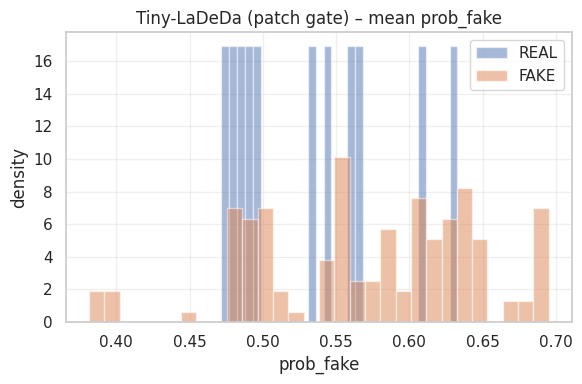

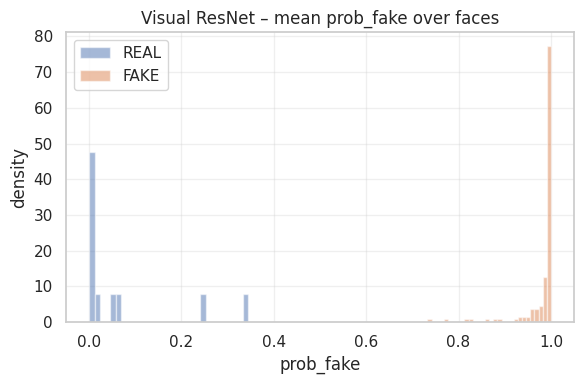

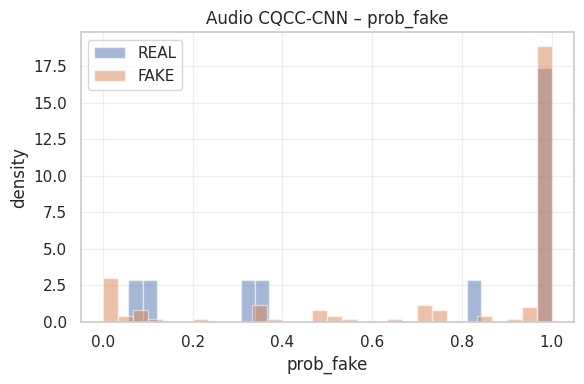

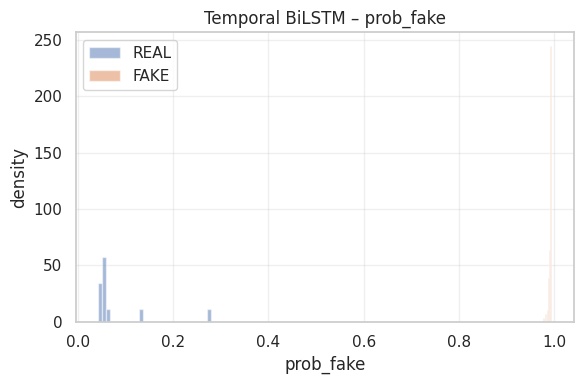

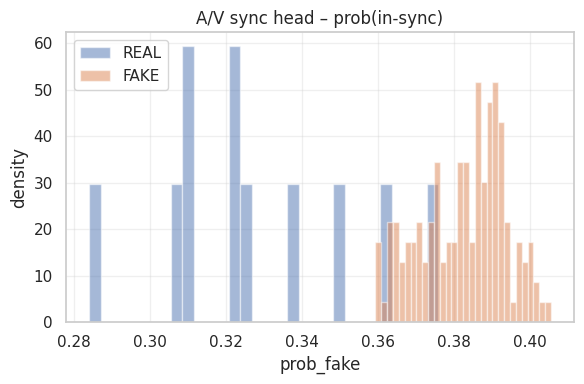

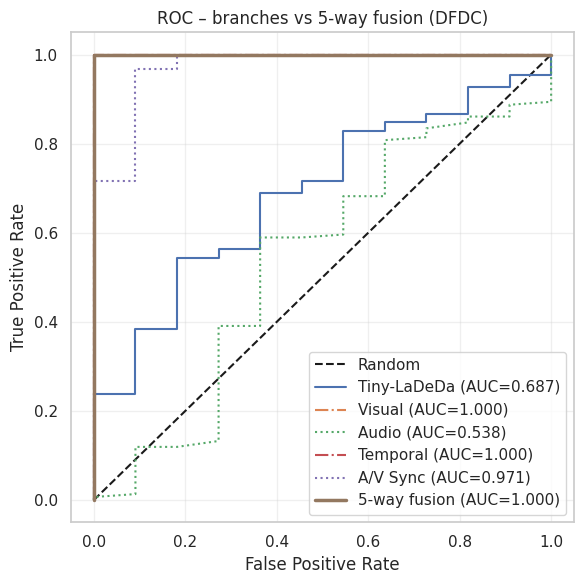


[INFO] 5-way fusion confusion matrix on TEST [rows=true, cols=pred]:
[[ 2  0]
 [ 0 31]]


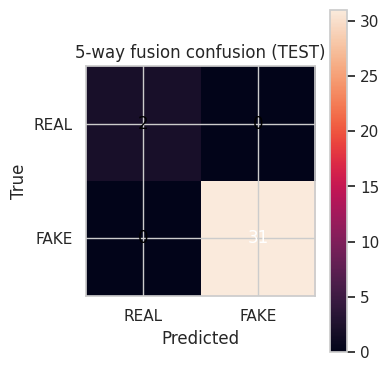


=== 5-way Modality Ablation Study (DFDC) ===


,Modalities,Num_features,ACC,F1,AUC,Num_test,Positives_test
0,Visual,4,1.000000,1.000000,1.000000,33,31
1,Sync,1,0.878788,0.931034,1.000000,33,31
2,Temporal,1,1.000000,1.000000,1.000000,33,31
3,Tiny+Visual,9,1.000000,1.000000,1.000000,33,31
4,Visual+Audio,5,1.000000,1.000000,1.000000,33,31
5,Tiny+Sync,6,0.939394,0.966667,1.000000,33,31
6,Tiny+Temporal,6,1.000000,1.000000,1.000000,33,31
7,Visual+Sync,5,1.000000,1.000000,1.000000,33,31
8,Audio+Temporal,2,1.000000,1.000000,1.000000,33,31
9,Audio+Sync,2,0.969697,0.983607,1.000000,33,31


In [115]:
# === Block 2: Visual inspection and ablation study for 5-way fusion ===
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import itertools

# ------------- 1) Helper: histograms per branch (what each stage focuses on) -------------

def plot_score_hist(df, col, title):
    plt.figure(figsize=(6, 4))
    for lbl, name in [(0, "REAL"), (1, "FAKE")]:
        vals = df.loc[df["label_int"] == lbl, col]
        if len(vals) == 0:
            continue
        plt.hist(vals, bins=30, alpha=0.5, density=True, label=name)
    plt.title(title)
    plt.xlabel("prob_fake")
    plt.ylabel("density")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

print("\n[INFO] Visualizing per-branch score distributions (REAL vs FAKE)...")

plot_score_hist(fusion5_df, "tiny_prob_mean",      "Tiny-LaDeDa (patch gate) – mean prob_fake")
plot_score_hist(fusion5_df, "visual_prob_mean",    "Visual ResNet – mean prob_fake over faces")
plot_score_hist(fusion5_df, "audio_prob_fake",     "Audio CQCC-CNN – prob_fake")
plot_score_hist(fusion5_df, "temporal_prob_fake",  "Temporal BiLSTM – prob_fake")
plot_score_hist(fusion5_df, "sync_prob",           "A/V sync head – prob(in-sync)")

# ------------- 2) ROC curves: per-branch vs 5-way fusion -------------

def add_branch_roc(ax, df, score_col, label, style="-"):
    probs = df[score_col].values
    y     = df["label_int"].values
    fpr, tpr, _ = roc_curve(y, probs)
    auc = roc_auc_score(y, probs)
    ax.plot(fpr, tpr, style, label=f"{label} (AUC={auc:.3f})")

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot([0, 1], [0, 1], "k--", label="Random")

add_branch_roc(ax, fusion5_df, "tiny_prob_mean",      "Tiny-LaDeDa", "-")
add_branch_roc(ax, fusion5_df, "visual_prob_mean",    "Visual",      "-.")
add_branch_roc(ax, fusion5_df, "audio_prob_fake",     "Audio",       ":")
add_branch_roc(ax, fusion5_df, "temporal_prob_fake",  "Temporal",    "-.")
add_branch_roc(ax, fusion5_df, "sync_prob",           "A/V Sync",    ":")

# 5-way fusion ROC (on all DFDC, not just X_test)
X_full = fusion5_df[feature_cols5].values
y_full = fusion5_df["label_int"].values
p_full = clf5.predict_proba(X_full)[:, 1]
fpr_f, tpr_f, _ = roc_curve(y_full, p_full)
auc_f = roc_auc_score(y_full, p_full)
ax.plot(fpr_f, tpr_f, "-", linewidth=2.5, label=f"5-way fusion (AUC={auc_f:.3f})")

ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("ROC – branches vs 5-way fusion (DFDC)")
ax.grid(True, alpha=0.3)
ax.legend()
plt.tight_layout()
plt.show()

# ------------- 3) Confusion matrix for 5-way fusion (on X_test) -------------
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, (clf5.predict_proba(X_test)[:,1] >= 0.5).astype(int))
print("\n[INFO] 5-way fusion confusion matrix on TEST [rows=true, cols=pred]:")
print(cm)

plt.figure(figsize=(4,4))
plt.imshow(cm, interpolation="nearest")
plt.title("5-way fusion confusion (TEST)")
plt.colorbar()
tick_marks = [0,1]
plt.xticks(tick_marks, ["REAL", "FAKE"])
plt.yticks(tick_marks, ["REAL", "FAKE"])
plt.xlabel("Predicted")
plt.ylabel("True")
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="white" if cm[i,j] > cm.max()/2 else "black")
plt.tight_layout()
plt.show()

# ------------- 4) Modality-level ablation study (Tiny / Visual / Audio / Temporal / Sync) -------------

MODALITY_GROUPS = {
    "Tiny":      ["tiny_prob_mean", "tiny_prob_max", "tiny_prob_p90",
                  "tiny_num_files", "tiny_num_patches"],
    "Visual":    ["visual_prob_mean", "visual_prob_max", "visual_prob_p90",
                  "visual_num_faces"],
    "Audio":     ["audio_prob_fake"],
    "Temporal":  ["temporal_prob_fake"],
    "Sync":      ["sync_prob"],
}

def evaluate_modality_subset(df, modality_names, random_state=42):
    """
    Train a fresh LogisticRegression on the selected modalities and report metrics.
    """
    cols = []
    for m in modality_names:
        cols.extend(MODALITY_GROUPS[m])

    X = df[cols].values
    y = df["label_int"].values

    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=random_state
    )

    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(
            max_iter=2000,
            class_weight="balanced"   # important due to imbalance (151 vs 11)
        )),
    ])

    pipe.fit(X_tr, y_tr)
    p_te = pipe.predict_proba(X_te)[:,1]
    y_hat = (p_te >= 0.5).astype(int)

    auc  = roc_auc_score(y_te, p_te)
    acc  = accuracy_score(y_te, y_hat)
    f1   = f1_score(y_te, y_hat)

    return {
        "Modalities": "+".join(modality_names),
        "Num_features": len(cols),
        "ACC": acc,
        "F1": f1,
        "AUC": auc,
        "Num_test": len(y_te),
        "Positives_test": int(y_te.sum()),
    }

# Build ablation table: 1-way up to 5-way
ablation_rows = []

modalities = list(MODALITY_GROUPS.keys())

# 1-way
for m in modalities:
    ablation_rows.append(evaluate_modality_subset(fusion5_df, [m]))

# 2-way
for comb in itertools.combinations(modalities, 2):
    ablation_rows.append(evaluate_modality_subset(fusion5_df, list(comb)))

# 3-way
for comb in itertools.combinations(modalities, 3):
    ablation_rows.append(evaluate_modality_subset(fusion5_df, list(comb)))

# 4-way
for comb in itertools.combinations(modalities, 4):
    ablation_rows.append(evaluate_modality_subset(fusion5_df, list(comb)))

# 5-way (all modalities)
ablation_rows.append(evaluate_modality_subset(fusion5_df, modalities))

ablation_df = pd.DataFrame(ablation_rows)
ablation_df = ablation_df.sort_values(by="AUC", ascending=False).reset_index(drop=True)

print("\n=== 5-way Modality Ablation Study (DFDC) ===")
display(ablation_df)


In [116]:
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, classification_report
import numpy as np
import pandas as pd

# We already have:
# - fusion5_df        (DFDC-only table with 5-way features)
# - bundle5           (joblib.load of 5-way model)
# We'll reuse its canonical feature order:
feature_cols5 = bundle5["feature_cols"]

X_all = fusion5_df[feature_cols5].values
y_all = fusion5_df["label_int"].values

print("[INFO] Cross-val input shapes:")
print("X_all:", X_all.shape, " y_all:", y_all.shape)
print("Label balance:", np.bincount(y_all))

def run_5way_cv(X, y, feature_names, n_splits=5, random_state=123):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    fold_metrics = []

    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), start=1):
        X_tr, X_te = X[train_idx], X[test_idx]
        y_tr, y_te = y[train_idx], y[test_idx]

        clf = Pipeline([
            ("scaler", StandardScaler()),
            ("logreg", LogisticRegression(max_iter=2000)),
        ])
        clf.fit(X_tr, y_tr)

        y_prob = clf.predict_proba(X_te)[:, 1]
        y_pred = (y_prob >= 0.5).astype(int)

        auc = roc_auc_score(y_te, y_prob)
        acc = accuracy_score(y_te, y_pred)
        f1  = f1_score(y_te, y_pred)

        fold_metrics.append({
            "fold": fold,
            "AUC": auc,
            "ACC": acc,
            "F1": f1,
            "N_test": len(y_te),
            "pos_test": int((y_te == 1).sum()),
            "neg_test": int((y_te == 0).sum()),
        })

        print(f"\n=== Fold {fold} ===")
        print(f"AUC={auc:.4f}, ACC={acc:.4f}, F1={f1:.4f}, "
              f"pos={fold_metrics[-1]['pos_test']}, neg={fold_metrics[-1]['neg_test']}")
        print(classification_report(y_te, y_pred, digits=4))

    cv_df = pd.DataFrame(fold_metrics)
    print("\n=== 5-way CV summary ===")
    print(cv_df)
    print("\nMean over folds:")
    print(cv_df[["AUC", "ACC", "F1"]].mean())

    return cv_df

cv5_df = run_5way_cv(X_all, y_all, feature_cols5, n_splits=5, random_state=123)


[INFO] Cross-val input shapes:
X_all: (162, 12)  y_all: (162,)
Label balance: [ 11 151]

=== Fold 1 ===
AUC=1.0000, ACC=1.0000, F1=1.0000, pos=31, neg=2
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         2
           1     1.0000    1.0000    1.0000        31

    accuracy                         1.0000        33
   macro avg     1.0000    1.0000    1.0000        33
weighted avg     1.0000    1.0000    1.0000        33


=== Fold 2 ===
AUC=1.0000, ACC=1.0000, F1=1.0000, pos=30, neg=3
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000         3
           1     1.0000    1.0000    1.0000        30

    accuracy                         1.0000        33
   macro avg     1.0000    1.0000    1.0000        33
weighted avg     1.0000    1.0000    1.0000        33


=== Fold 3 ===
AUC=1.0000, ACC=1.0000, F1=1.0000, pos=30, neg=2
              precision    recall  f1-score   support

        

In [117]:
from sklearn.model_selection import train_test_split
from scipy.special import logit
from scipy.optimize import minimize

# Use canon feature order
feature_cols5 = bundle5["feature_cols"]
clf5 = bundle5["model"]

X_all = fusion5_df[feature_cols5].values
y_all = fusion5_df["label_int"].values.astype(np.float32)

X_tr_cal, X_val_cal, y_tr_cal, y_val_cal = train_test_split(
    X_all, y_all, test_size=0.2, stratify=y_all, random_state=999
)

# Freeze clf5; only learn T on validation set
p_val = clf5.predict_proba(X_val_cal)[:, 1].clip(1e-6, 1-1e-6)
z_val = logit(p_val)

def nll_with_T(log_T):
    T = np.exp(log_T)       # enforce T > 0
    z_scaled = z_val / T
    p_scaled = 1.0 / (1.0 + np.exp(-z_scaled))
    eps = 1e-6
    p_scaled = np.clip(p_scaled, eps, 1-eps)
    nll = -(y_val_cal * np.log(p_scaled) + (1-y_val_cal)*np.log(1-p_scaled)).mean()
    return nll

res = minimize(nll_with_T, x0=np.array([0.0]), method="L-BFGS-B")
log_T_opt = float(res.x[0])
T_opt = float(np.exp(log_T_opt))
print(f"[CAL] Optimal temperature T for 5-way fusion: {T_opt:.4f}")

def apply_temperature(p, T):
    p = np.clip(p, 1e-6, 1-1e-6)
    z = logit(p)
    z_scaled = z / T
    return 1.0 / (1.0 + np.exp(-z_scaled))

# Evaluate calibration quality on the same val set (just to inspect)
p_val_cal = apply_temperature(p_val, T_opt)

from sklearn.metrics import brier_score_loss

brier_before = brier_score_loss(y_val_cal, p_val)
brier_after  = brier_score_loss(y_val_cal, p_val_cal)
print(f"[CAL] Brier score before: {brier_before:.4f}, after: {brier_after:.4f}")

# Sweep thresholds to get idea for confident_real / confident_fake bands
for thr in [0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9]:
    pred = (p_val_cal >= thr).astype(np.int32)
    tp = ((pred == 1) & (y_val_cal == 1)).sum()
    fp = ((pred == 1) & (y_val_cal == 0)).sum()
    tn = ((pred == 0) & (y_val_cal == 0)).sum()
    fn = ((pred == 0) & (y_val_cal == 1)).sum()

    fpr = fp / max(fp + tn, 1)
    tpr = tp / max(tp + fn, 1)
    print(f"thr={thr:.2f} | FPR={fpr:.3f}, TPR={tpr:.3f}, TP={tp}, FP={fp}")


[CAL] Optimal temperature T for 5-way fusion: 0.3679
[CAL] Brier score before: 0.0000, after: 0.0000
thr=0.10 | FPR=0.000, TPR=1.000, TP=31, FP=0
thr=0.20 | FPR=0.000, TPR=1.000, TP=31, FP=0
thr=0.30 | FPR=0.000, TPR=1.000, TP=31, FP=0
thr=0.50 | FPR=0.000, TPR=1.000, TP=31, FP=0
thr=0.70 | FPR=0.000, TPR=1.000, TP=31, FP=0
thr=0.80 | FPR=0.000, TPR=1.000, TP=31, FP=0
thr=0.90 | FPR=0.000, TPR=1.000, TP=31, FP=0


In [118]:
THR_REAL = 0.2   # p_cal <= 0.2 → confidently REAL
THR_FAKE = 0.8   # p_cal >= 0.8 → confidently FAKE


In [119]:
bundle5["temperature"] = T_opt
joblib.dump(bundle5, WORK_ROOT / "models" / "clip_fusion_logreg_5way_calibrated.joblib")
print("[CAL] Saved calibrated 5-way bundle with temperature to:", WORK_ROOT / "models" / "clip_fusion_logreg_5way_calibrated.joblib")


[CAL] Saved calibrated 5-way bundle with temperature to: /kaggle/working/deepfake_detector/models/clip_fusion_logreg_5way_calibrated.joblib


In [121]:
import numpy as np

def apply_temperature(p_raw, T: float):
    """
    p_raw: np.ndarray of shape (N,) with probabilities in (0,1)
    T    : scalar temperature
    Returns: np.ndarray of shape (N,) with calibrated probabilities
    """
    p = np.clip(p_raw, 1e-6, 1 - 1e-6)
    logit = np.log(p / (1.0 - p))
    logit_scaled = logit / T
    p_scaled = 1.0 / (1.0 + np.exp(-logit_scaled))
    return p_scaled


In [122]:
import joblib
from pathlib import Path

WORK_ROOT = Path("/kaggle/working/deepfake_detector")

bundle5   = joblib.load(WORK_ROOT / "models" / "clip_fusion_logreg_5way_calibrated.joblib")
clf5      = bundle5["model"]
feat_cols5 = bundle5["feature_cols"]
T_opt     = bundle5.get("temperature", 1.0)

print("Feature cols in bundle:", feat_cols5)
print("Temperature:", T_opt)


Feature cols in bundle: ['tiny_prob_mean', 'tiny_prob_max', 'tiny_prob_p90', 'visual_prob_mean', 'visual_prob_max', 'visual_prob_p90', 'visual_num_faces', 'tiny_num_files', 'tiny_num_patches', 'audio_prob_fake', 'temporal_prob_fake', 'sync_prob']
Temperature: 0.3678794411714424


In [123]:
f_row = fusion5_df.iloc[0]

In [124]:
# Make sure we pull the features in the SAME order the model expects
x = f_row[feat_cols5].values.reshape(1, -1)

# Raw prob from logistic regression
p_raw = clf5.predict_proba(x)[:, 1]

# Calibrated prob via temperature scaling
p_cal = apply_temperature(p_raw, T_opt)[0]

print("Raw prob   :", float(p_raw[0]))
print("Calib prob :", float(p_cal))


Raw prob   : 0.9972994607739658
Calib prob : 0.999999895009286


In [125]:
def fusion5_predict_from_row(f_row, bundle):
    clf = bundle["model"]
    feat_cols = bundle["feature_cols"]
    T_opt = bundle.get("temperature", 1.0)

    x = f_row[feat_cols].values.reshape(1, -1)
    p_raw = clf.predict_proba(x)[:, 1]

    if T_opt != 1.0:
        p_cal = apply_temperature(p_raw, T_opt)[0]
    else:
        p_cal = p_raw[0]

    return float(p_cal)
                                                       

In [126]:
p_clip0 = fusion5_predict_from_row(fusion5_df.iloc[0], bundle5)
print("Fusion 5-way calibrated prob (clip 0):", p_clip0)

Fusion 5-way calibrated prob (clip 0): 0.999999895009286
